In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports de base
import re
import time
import string
import pickle

import numpy as np
import pandas as pd

from functools import partial

# Pour la détection de la langue du dataset
!pip install -q langdetect
from langdetect import detect, detect_langs

# Fonctions scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, 
                             log_loss, 
                             f1_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split,
                                     cross_val_score, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     KFold)

# Modèles Machine Learning
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier

# Fonctions Skopt (hyperparamètres)
!pip install -q scikit-optimize
from skopt import gp_minimize
from skopt import space

# POur la data exploration
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Exploration des données
Petite exploration des données.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/datafake_train.csv', encoding='utf-8', sep=';')
df.head()

media                                               post  fake
0  unknown  Sénatoriales : les résultats des élections.La ...     0
1  unknown                 Live Spécial François Fillon\r\n27     1
2  unknown  Notre-Dame-des-Landes : « La décision prise pa...     0
3  unknown  Chasse: silence, on tire.Avec l'autorisation d...     0
4  unknown  Payet lance un appel à l’OM : « S’il vous plaî...     1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6645 entries, 0 to 6644
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   media   6645 non-null   object
 1   post    6645 non-null   object
 2   fake    6645 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 155.9+ KB


In [ ]:
# Media ne contient aucune information.
df = df.drop(['media'], axis=1)

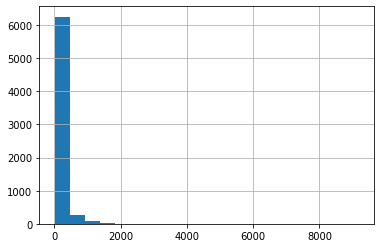

In [ ]:
# Analyse de la taille des textes (en mots) 
df['len'] = df['post'].transform(lambda x:len(x.split()))
df['len'].hist(bins=20)

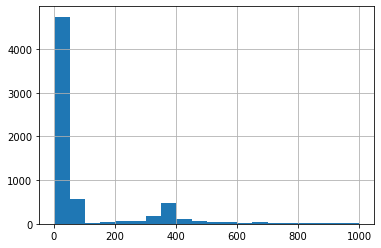

In [ ]:
# On restreint le nombre de mots maximum à 1000 pour cette étude
# Plus le texte est long et plus son analyse est délicate et couteuse (puissance & temps de calcul)
df_1000 = df[df['len'] < 1000]
df_1000['len'].hist(bins=20)

In [ ]:
# Vérification de la proportion de fake vs real news dans le nouveau Dataset. (même Dataset en excluant les textes supérieurs à 1000 mots)
# Conclusion : le dataset est équilibré
df_1000['fake'].value_counts(normalize=True)

0    0.504808
1    0.495192
Name: fake, dtype: float64

In [ ]:
# Vérification de la langue du dataset
# Conclusion : certains textes ne sont pas en français et d'autres ne ressemblent pas à des news
non_fr = []
for i,txt in enumerate(df_1000.post) :
    try :
        lg = detect(txt.lower())         # Tout mettre en minuscule, ça aide à la détection de langue
    except :
        non_fr.append((i,txt))
    
    if lg != 'fr' :
        non_fr.append((i,txt))

In [ ]:
# les textes n°624, 1187, 1193, 3886, 4082, 4859 ne sont pas français
non_fr

[(218, 'Monde de merde\r\n484'),
 (272,
  'Windows 10 - Internet Explorer change de nom pour devenir « Google Chrome Installator »\r\n98'),
 (588,
  'CREEPY PASTA 20 JANVIER 2018\r\nCREEPY PASTA : LE LOUP GAROU DE MUNDOLSHEIM'),
 (592, 'Monsanto va breveter l’acte de respirer\r\n127'),
 (617, 'Confort - La SNCF va équiper ses TGV de wagons individuels\r\n81'),
 (624,
  'The EU refuses to validate the British referendum due to non-conforming ballots to the norm of the EU\r\n84'),
 (1187,
  '⠨⠥⠝ ⠋⠗⠁⠝⠯⠁⠊⠎ ⠓⠑⠥⠗⠑⠥⠭ ⠙⠑ ⠇⠊⠗⠑ ⠑⠝⠋⠊⠝ ⠥⠝ ⠁⠗⠞⠊⠉⠇⠑ ⠟⠥⠊ ⠝⠑ ⠞⠗⠁⠊⠞⠑ ⠏⠁⠎ ⠙⠑ ⠇’⠿⠇⠑⠉⠞⠊⠕⠝ ⠏⠗⠿⠎⠊⠙⠑⠝⠞⠊⠑⠇⠇⠑\r\n127'),
 (1193, 'Lorem ipsum dolor sit amet, consectetuer adipiscing elit\r\n206'),
 (1351,
  'CREEPY PASTA 20 JANVIER 2018\r\nCREEPY PASTA : LA SORCIèRE DE LA FORET HENTAI'),
 (1783, 'Manuel Valls « Burkini ! »\r\n46'),
 (2500, '« Mon appli Tinder bugge » par votre ami moche\r\n23'),
 (2803,
  'Costa-Rica : InGen refuse de fermer son parc zoologique de Isla Nublar\r\n52'),
 (3792, 'Balance ton 2017 : #bala

**Mots les plus présents dans les fake news.**

In [ ]:
# téléchargement des stopwords (mots fréquents) français
nltk.download('stopwords')
banwords = stopwords.words('french') + ['plu', 'cette', 'tout', 'après', 'toute', 'faire', 'être', 'tou', 'très', 'plus', 'selon', 'bien', 'com', 'comme', 'avoir', 'tous']

# Concaténation de tous les fakes news en une seule
text = ' '.join(df_1000[df.fake == 1]['post'].values)

wc = WordCloud(width = 1600, 
               height = 800, 
               collocations = False, 
               stopwords = banwords,
               background_color = 'white').generate(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


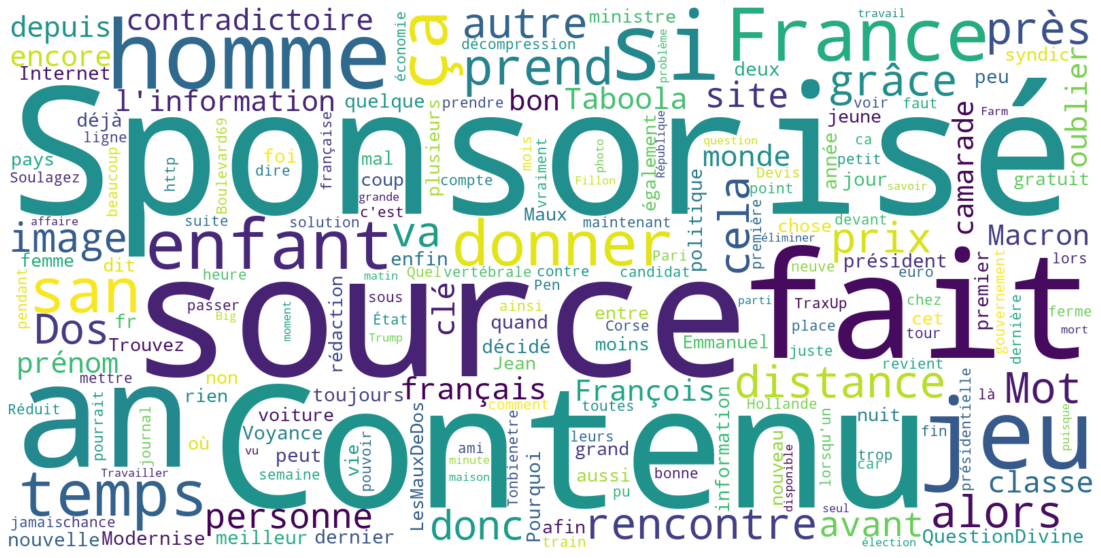

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Mots les plus présents dans les real news.**

In [ ]:
# Concaténation de tous les real news en une seule
text = ' '.join(df_1000[df.fake == 0]['post'].values)

wc = WordCloud(width = 1600, 
               height = 800, 
               collocations = False, 
               stopwords = banwords,
               background_color = 'white').generate(text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


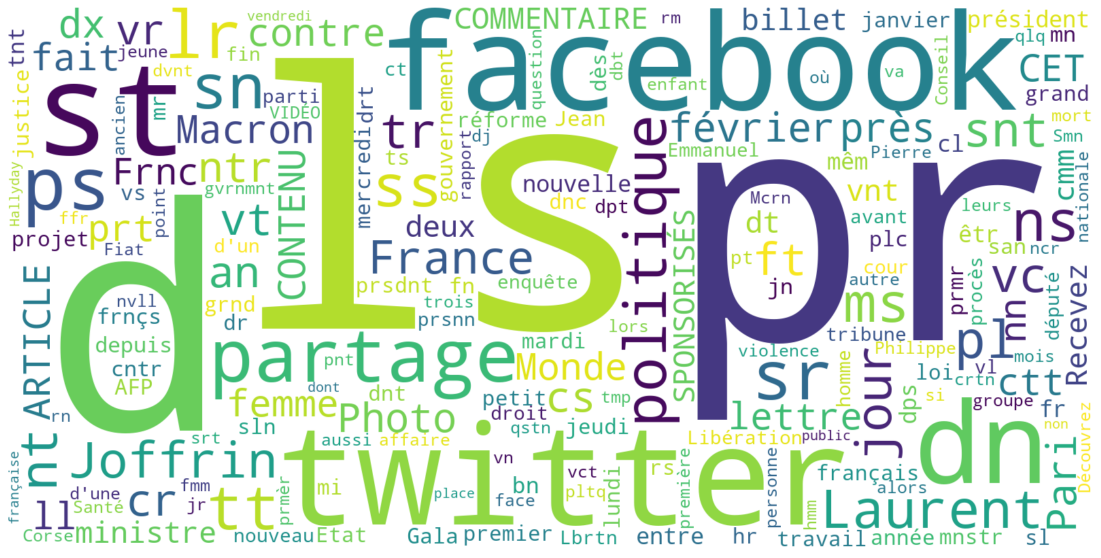

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# Pré-traitement

## Nettoyage du dataset

In [ ]:
# Suppression des textes non français
df_train = df_1000.copy().drop(index=[624, 1187, 1193, 3886, 4082, 4859], axis=0)
df_train = df_train.reset_index(drop=True)

In [ ]:
X_train = df_train.copy().drop('len', axis=1)
y_train = X_train.pop('fake')

In [ ]:
# Nettoyage du texte (ponctuation, artefacts (\n, \r), chiffres, majuscules, non latin)
def clean_text(txt):
    # majuscules
    txt = txt.lower()

    # ponctuation
    txt = re.sub('['+string.punctuation+']', ' ', txt)
    txt = re.sub('[«"]', ' ', txt)

    # artefacts
    txt = re.sub('[\r]', ' ', txt)
    txt = re.sub('[\n]', ' ', txt)

    # chiffres
    txt = re.sub(r'\s*\d+\s*', ' ', txt)

    # alphabets étrangers
    txt = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿ/]+', ' ', txt)
    
    return txt

In [ ]:
X_train_pp = X_train['post'].apply(clean_text)
X_train_pp

0       sénatoriales   les résultats des élections la ...
1                           live spécial françois fillon 
2       notre dame des landes     la décision prise pa...
3       chasse  silence  on tire avec l autorisation d...
4       payet lance un appel à l om     s il vous plaî...
                              ...                        
6540    droit de suite  après les bousculades pour du ...
6541    corruption  féminisme  lanceur d alerte  madam...
6542    barbier    comment macron a sauvé la terre en ...
6543    selon pierre gattaz la cgt dispose de camps d ...
6544    le roman fantôme d isaac bashevis singer   kei...
Name: post, Length: 6545, dtype: object

## Méthode n°1 : Simple vectorisation 

In [ ]:
# le nombre de mots gardés
max_1gram = 2500

# le nombre de bi-gram gardés
# bi-gram = deux mots qui se suivent
max_2gram = 1000

In [ ]:
words = CountVectorizer(ngram_range=(1,1),
                        analyzer='word',
                        max_features=max_1gram)

bigrams = CountVectorizer(ngram_range=(2,2),
                          analyzer='word',
                          max_features=max_2gram)

X_words = words.fit_transform(X_train_pp)
X_bigrams = bigrams.fit_transform(X_train_pp)

In [ ]:
words.get_feature_names_out()[:20]

array(['abandon', 'abarth', 'abdeslam', 'abord', 'absence', 'accepté',
       'accident', 'accord', 'accorder', 'accueil', 'accusations',
       'accusé', 'accusée', 'accès', 'achat', 'acheter', 'acte', 'actes',
       'acteur', 'action'], dtype=object)

In [ ]:
bigrams.get_feature_names_out()[:20]

array(['accepté de', 'afin de', 'afin qu', 'afin que', 'afp facebook',
       'ai pas', 'aide les', 'ainsi que', 'alors qu', 'alors que',
       'alpes cote', 'amour en', 'ans de', 'ans en', 'après avoir',
       'après cet', 'après la', 'après le', 'après les', 'après nos'],
      dtype=object)

In [ ]:
X_train_count = pd.concat([pd.DataFrame(X_words.toarray(), columns=words.get_feature_names_out()),
                           pd.DataFrame(X_bigrams.toarray(), columns=bigrams.get_feature_names_out())],
                          axis=1)
X_train_count

abandon  abarth  abdeslam  abord  absence  accepté  accident  accord  \
0           0       0         0      0        0        0         0       0   
1           0       0         0      0        0        0         0       0   
2           1       0         0      0        0        0         0       0   
3           0       0         0      0        0        0         0       0   
4           0       0         0      0        0        0         0       1   
...       ...     ...       ...    ...      ...      ...       ...     ...   
6540        0       0         0      0        0        0         0       0   
6541        0       0         0      0        0        0         0       0   
6542        0       0         0      0        0        0         0       0   
6543        0       0         0      0        0        0         0       0   
6544        0       0         0      0        0        0         0       0   

      accorder  accueil  ...  ça va  économies et  élection présidentielle  \
0            0        0  ...      0             0                        0   
1            0        0  ...      0             0                        0   
2            0        0  ...      0             0                        0   
3            0        0  ...      0             0                        0   
4            0        0  ...      0             0                        0   
...        ...      ...  ...    ...           ...                      ...   
6540         0        0  ...      0             0                        0   
6541         0        0  ...      0             0                        0   
6542         0        0  ...      0             0                        0   
6543         0        0  ...      0             0                        0   
6544         0        0  ...      0             0                        0   

      éliminer votre  équipe de  était pas  était un  états unis  \
0                  0          0          0         0           0   
1                  0          0          0         0           0   
2                  0          0          0         0           0   
3                  0          0          0         0           0   
4                  0          1          0         0           0   
...              ...        ...        ...       ...         ...   
6540               0          0          0         0           0   
6541               0          0          0         0           0   
6542               0          0          0         0           0   
6543               0          0          0         0           0   
6544               0          0          0         0           0   

      éveillé toute  être un  
0                 0        0  
1                 0        0  
2                 0        0  
3                 0        0  
4                 0        0  
...             ...      ...  
6540              0        0  
6541              0        0  
6542              0        0  
6543              0        0  
6544              0        0  

[6545 rows x 3500 columns]

## Méthode 2 : tf-idf vectorisation

In [ ]:
# le nombre de mots gardés
max_1gram = 2500

# le nombre de bi-gram gardés
max_2gram = 1000

In [ ]:
tfidf_words = TfidfVectorizer(ngram_range=(1,1),
                              analyzer='word',
                              max_features=max_1gram)

tfidf_bigrams = TfidfVectorizer(ngram_range=(2,2),
                                analyzer='word',
                                max_features=max_2gram)

X_tfidf_words = tfidf_words.fit_transform(X_train_pp)
X_tfidf_bigrams = tfidf_bigrams.fit_transform(X_train_pp)

In [ ]:
tfidf_words.get_feature_names_out()[:20]

array(['abandon', 'abarth', 'abdeslam', 'abord', 'absence', 'accepté',
       'accident', 'accord', 'accorder', 'accueil', 'accusations',
       'accusé', 'accusée', 'accès', 'achat', 'acheter', 'acte', 'actes',
       'acteur', 'action'], dtype=object)

In [ ]:
tfidf_bigrams.get_feature_names_out()[:20]

array(['accepté de', 'afin de', 'afin qu', 'afin que', 'afp facebook',
       'ai pas', 'aide les', 'ainsi que', 'alors qu', 'alors que',
       'alpes cote', 'amour en', 'ans de', 'ans en', 'après avoir',
       'après cet', 'après la', 'après le', 'après les', 'après nos'],
      dtype=object)

In [ ]:
X_train_tfidf = pd.concat([pd.DataFrame(X_tfidf_words.toarray(), columns=tfidf_words.get_feature_names_out()),
                           pd.DataFrame(X_tfidf_bigrams.toarray(), columns=tfidf_bigrams.get_feature_names_out())],
                          axis=1)

In [ ]:
# Normalisation du jeu d'entrainement
std_tfidf = StandardScaler()
X_train_tfidf_std = std_tfidf.fit_transform(X_train_count)
X_train_tfidf_std = pd.DataFrame(X_train_tfidf_std, columns=std_tfidf.feature_names_in_)
X_train_tfidf_std

abandon   abarth  abdeslam     abord   absence   accepté  accident  \
0     -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
1     -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
2     13.446857 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
3     -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
4     -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
...         ...      ...       ...       ...       ...       ...       ...   
6540  -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
6541  -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
6542  -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
6543  -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   
6544  -0.066068 -0.06149 -0.046666 -0.093176 -0.063139 -0.109424 -0.065475   

        accord  accorder   accueil  ...     ça va  économies et  \
0    -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
1    -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
2    -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
3    -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
4     5.252792 -0.081943 -0.063725  ... -0.076531     -0.157792   
...        ...       ...       ...  ...       ...           ...   
6540 -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
6541 -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
6542 -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
6543 -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   
6544 -0.119848 -0.081943 -0.063725  ... -0.076531     -0.157792   

      élection présidentielle  éliminer votre  équipe de  était pas  était un  \
0                   -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
1                   -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
2                   -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
3                   -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
4                   -0.084632       -0.164283   7.390473  -0.093584 -0.075864   
...                       ...             ...        ...        ...       ...   
6540                -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
6541                -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
6542                -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
6543                -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   
6544                -0.084632       -0.164283  -0.082205  -0.093584 -0.075864   

      états unis  éveillé toute   être un  
0      -0.082975      -0.157792 -0.089978  
1      -0.082975      -0.157792 -0.089978  
2      -0.082975      -0.157792 -0.089978  
3      -0.082975      -0.157792 -0.089978  
4      -0.082975      -0.157792 -0.089978  
...          ...            ...       ...  
6540   -0.082975      -0.157792 -0.089978  
6541   -0.082975      -0.157792 -0.089978  
6542   -0.082975      -0.157792 -0.089978  
6543   -0.082975      -0.157792 -0.089978  
6544   -0.082975      -0.157792 -0.089978  

[6545 rows x 3500 columns]

# Entrainement

## Premiers tests

On test plusieurs modèles de classification pour ne garder que les plus prometteurs.

La fonction ci-dessous utilise une cross_validation pour entrainer tous les modèles les uns après les autres.

In [ ]:
seed=42

# Tous les modèles à tester
models = {
    'log' : LogisticRegression(max_iter = 1000, random_state = seed),
    'rid' : RidgeClassifier(random_state = seed),

    'sgd' : SGDClassifier(random_state = seed),

    'lsvc' : LinearSVC(random_state = seed),

    'rfc' : RandomForestClassifier(random_state = seed),
    'etc' : ExtraTreeClassifier(random_state = seed),
    'dtc' : DecisionTreeClassifier(random_state = seed),

    'abc' : AdaBoostClassifier(random_state = seed),
    'gbc' : GradientBoostingClassifier(random_state = seed),

    'knn' : KNeighborsClassifier(),

    'xgb': XGBClassifier(use_label_encoder=False, verbosity=0, random_state = seed),
    'lgbm' : LGBMClassifier(verbosity = 0, random_state = seed),
	
    'mlp' : MLPClassifier(early_stopping = True, random_state = seed),
}

# Fonction qui test les modèles
def model_selection(models, X, y, cv = 3, scoring = 'accuracy'):
    scores = []
    
    for name, model in models.items() :
        t0 = time.time()
        score = cross_val_score(model, X, y, cv = cv, scoring = scoring, verbose=0)

        # On mesure le score moyen (accuracy) et son écart type ainsi que le temps 
        scores.append((name, 
                        time.time()-t0,
                        np.round(np.mean(score),3), 
                        np.round(np.std(score),3)))
        scores.sort(key = lambda x : x[2], reverse=True)                                            
    return scores

**Test du vectorizer Count.**

In [ ]:
scores = model_selection(models, X_train_count, y_train)

In [ ]:
for score in scores :
    print(f'name {score[0]} - Score : {score[2]} +/- {score[3]} - Time : {np.round(score[1])} sec')

name lgbm - Score : 0.947 +/- 0.004 - Time : 11.0 sec
name mlp - Score : 0.938 +/- 0.006 - Time : 30.0 sec
name log - Score : 0.932 +/- 0.004 - Time : 13.0 sec
name rfc - Score : 0.932 +/- 0.006 - Time : 13.0 sec
name sgd - Score : 0.92 +/- 0.007 - Time : 4.0 sec
name gbc - Score : 0.917 +/- 0.007 - Time : 61.0 sec
name lsvc - Score : 0.916 +/- 0.003 - Time : 2.0 sec
name xgb - Score : 0.915 +/- 0.007 - Time : 94.0 sec
name abc - Score : 0.911 +/- 0.009 - Time : 24.0 sec
name dtc - Score : 0.87 +/- 0.009 - Time : 4.0 sec
name etc - Score : 0.837 +/- 0.015 - Time : 1.0 sec
name rid - Score : 0.83 +/- 0.005 - Time : 10.0 sec
name knn - Score : 0.746 +/- 0.004 - Time : 10.0 sec


**Test du vectorizer Tfidf.**

In [ ]:
scores = model_selection(models, X_train_tfidf_std, y_train)

In [ ]:
for score in scores :
    print(f'name {score[0]} - Score : {score[2]} +/- {score[3]} - Time : {np.round(score[1])} sec')

name lgbm - Score : 0.947 +/- 0.004 - Time : 48.0 sec
name mlp - Score : 0.935 +/- 0.004 - Time : 28.0 sec
name rfc - Score : 0.933 +/- 0.006 - Time : 13.0 sec
name gbc - Score : 0.917 +/- 0.007 - Time : 55.0 sec
name xgb - Score : 0.915 +/- 0.007 - Time : 96.0 sec
name log - Score : 0.912 +/- 0.002 - Time : 10.0 sec
name abc - Score : 0.911 +/- 0.009 - Time : 23.0 sec
name sgd - Score : 0.892 +/- 0.011 - Time : 3.0 sec
name lsvc - Score : 0.886 +/- 0.004 - Time : 44.0 sec
name dtc - Score : 0.87 +/- 0.009 - Time : 4.0 sec
name etc - Score : 0.837 +/- 0.015 - Time : 1.0 sec
name rid - Score : 0.767 +/- 0.009 - Time : 10.0 sec
name knn - Score : 0.558 +/- 0.009 - Time : 7.0 sec


**Les deux vectorizers se valent**.<br>
Dans la suite, on prendra le Count Vectorizer.

## Hyperparamétrisation

Ici, on améliore les hyperparamètres des modèles le plus possible !

### Logistic Regression

In [ ]:
# Chargement du modèle
log_reg = LogisticRegression(random_state=42, max_iter=1000)

**1ère étape : les solveurs et les pénalités**

Conclusion : Sag est beaucoup trop lent et n'apporte pas de meilleures performances.

In [ ]:
# Grille pour solveurs : newton, lbfgs et sag
param_grid = {'C' : [0.33,0.66,1],
              'solver': ['newton-cg', 'lbfgs', 'sag'],
              'penalty' : ['l2']}

# Recherche des hyperparamètres
gscv_log = GridSearchCV(log_reg, param_grid, cv=3, verbose=0)
gscv_log.fit(X_train_count, y_train)

# Affichage des résultats
gscv_log_df = pd.DataFrame(gscv_log.cv_results_)
gscv_log_df.sort_values(by='mean_test_score', ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       5.605647      0.037244         0.149699        0.004463    0.33   
1       2.686347      0.210271         0.146526        0.001714    0.33   
2     170.223010     17.972016         0.132215        0.003815    0.33   
6       6.393853      0.215505         0.148053        0.003183       1   
7       3.534624      0.275789         0.149131        0.005492       1   
5     166.792677      3.002156         0.128870        0.002206    0.66   
3       5.976241      0.011395         0.142324        0.002169    0.66   
4       3.313068      0.358749         0.151863        0.009063    0.66   
8     165.766618      1.292777         0.103861        0.006770       1   

  param_penalty param_solver  \
0            l2    newton-cg   
1            l2        lbfgs   
2            l2          sag   
6            l2    newton-cg   
7            l2        lbfgs   
5            l2          sag   
3            l2    newton-cg   
4            l2        lbfgs   
8            l2          sag   

                                              params  split0_test_score  \
0  {'C': 0.33, 'penalty': 'l2', 'solver': 'newton...           0.936297   
1    {'C': 0.33, 'penalty': 'l2', 'solver': 'lbfgs'}           0.936297   
2      {'C': 0.33, 'penalty': 'l2', 'solver': 'sag'}           0.935380   
6   {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}           0.934005   
7       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}           0.934005   
5      {'C': 0.66, 'penalty': 'l2', 'solver': 'sag'}           0.934464   
3  {'C': 0.66, 'penalty': 'l2', 'solver': 'newton...           0.934464   
4    {'C': 0.66, 'penalty': 'l2', 'solver': 'lbfgs'}           0.934464   
8         {'C': 1, 'penalty': 'l2', 'solver': 'sag'}           0.933547   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.926673           0.933975         0.932315        0.004101   
1           0.926673           0.933975         0.932315        0.004101   
2           0.928048           0.933058         0.932162        0.003060   
6           0.926673           0.934892         0.931857        0.003684   
7           0.926673           0.934892         0.931857        0.003684   
5           0.927131           0.933517         0.931704        0.003256   
3           0.925298           0.934434         0.931398        0.004314   
4           0.925298           0.934434         0.931398        0.004314   
8           0.926673           0.933058         0.931093        0.003132   

   rank_test_score  
0                1  
1                1  
2                3  
6                4  
7                4  
5                6  
3                7  
4                7  
8                9

Conclusion : Saga est également trop lent.

In [ ]:
# Grille pour solveur liblinear et saga      
param_grid = {'C' : [0.33,0.66,1],
              'solver': ['liblinear', 'saga'],
              'penalty' : ['l2', 'l1']},

gscv_log_2 = GridSearchCV(log_reg, param_grid, cv=3, verbose=0)
gscv_log_2.fit(X_train_count, y_train)

gscv_log_df_2 = pd.DataFrame(gscv_log_2.cv_results_)
gscv_log_df_2.sort_values(by='mean_test_score', ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
5      201.091725      1.518200         0.096746        0.001462    0.66   
9      201.799203      0.856445         0.093601        0.000969       1   
8        0.493046      0.032491         0.091910        0.002037       1   
0        0.447203      0.072996         0.093232        0.003433    0.33   
4        0.464247      0.057469         0.089303        0.001408    0.66   
1      200.695636      1.466695         0.096905        0.004648    0.33   
10       0.412910      0.042122         0.091112        0.002128       1   
11     361.307116      8.132619         0.095529        0.000392       1   
6        0.405556      0.033102         0.095805        0.004399    0.66   
7      323.904880      6.314745         0.110268        0.021149    0.66   
2        0.385220      0.068002         0.090658        0.000504    0.33   
3      281.070762      1.658247         0.093086        0.000227    0.33   

   param_penalty param_solver  \
5             l2         saga   
9             l2         saga   
8             l2    liblinear   
0             l2    liblinear   
4             l2    liblinear   
1             l2         saga   
10            l1    liblinear   
11            l1         saga   
6             l1    liblinear   
7             l1         saga   
2             l1    liblinear   
3             l1         saga   

                                               params  split0_test_score  \
5      {'C': 0.66, 'penalty': 'l2', 'solver': 'saga'}           0.935380   
9         {'C': 1, 'penalty': 'l2', 'solver': 'saga'}           0.934922   
8    {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}           0.935839   
0   {'C': 0.33, 'penalty': 'l2', 'solver': 'liblin...           0.934922   
4   {'C': 0.66, 'penalty': 'l2', 'solver': 'liblin...           0.934464   
1      {'C': 0.33, 'penalty': 'l2', 'solver': 'saga'}           0.933547   
10   {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}           0.934922   
11        {'C': 1, 'penalty': 'l1', 'solver': 'saga'}           0.932631   
6   {'C': 0.66, 'penalty': 'l1', 'solver': 'liblin...           0.928964   
7      {'C': 0.66, 'penalty': 'l1', 'solver': 'saga'}           0.928048   
2   {'C': 0.33, 'penalty': 'l1', 'solver': 'liblin...           0.924840   
3      {'C': 0.33, 'penalty': 'l1', 'solver': 'saga'}           0.921632   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
5            0.928048           0.934434         0.932621        0.003257   
9            0.927589           0.934892         0.932468        0.003450   
8            0.925756           0.935351         0.932315        0.004642   
0            0.928048           0.933975         0.932315        0.003042   
4            0.925756           0.933975         0.931398        0.003995   
1            0.926673           0.933517         0.931246        0.003233   
10           0.926214           0.932141         0.931093        0.003631   
11           0.926214           0.933517         0.930787        0.003254   
6            0.922548           0.931683         0.927732        0.003830   
7            0.919798           0.931224         0.926357        0.004815   
2            0.914757           0.922513         0.920703        0.004310   
3            0.910632           0.922971         0.918412        0.005528   

    rank_test_score  
5                 1  
9                 2  
8                 3  
0                 4  
4                 5  
1                 6  
10                7  
11                8  
6                 9  
7                10  
2                11  
3                12

Conclusion : Seuls les solveurs lfbgs et newton-cg semblent intéressant pour la suite.

**2ème étape : le paramètre C**

In [ ]:
param_grid = {'C' : np.linspace(0.01, 0.5, 10),
              'solver': ['newton-cg', 'lbfgs'],
              'penalty' : ['l2']},

gscv_log_3 = GridSearchCV(log_reg, param_grid, cv=3, verbose=0)
gscv_log_3.fit(X_train_count, y_train)

gscv_log_df_3 = pd.DataFrame(gscv_log_3.cv_results_)
gscv_log_df_3.sort_values(by='mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
13       4.247394      0.199804         0.151719        0.049902  0.336667   
12       8.235661      0.176229         0.142068        0.018459  0.336667   
15       3.188442      0.443158         0.109476        0.018497  0.391111   
14       6.307954      0.262160         0.088515        0.010077  0.391111   
8        6.418936      0.425813         0.090524        0.003430  0.227778   
9        2.643505      0.331436         0.098303        0.007664  0.227778   
10       8.127954      1.441897         0.124635        0.019034  0.282222   
11       4.395935      0.127184         0.138799        0.021041  0.282222   
19       3.418900      0.382490         0.118261        0.011555       0.5   
18       6.665284      0.556597         0.091978        0.004643       0.5   
16       6.539917      0.551069         0.099405        0.016427  0.445556   
17       2.942021      0.217000         0.100243        0.008279  0.445556   
7        2.762014      0.246098         0.111905        0.005836  0.173333   
6        5.023545      0.505724         0.095243        0.005279  0.173333   
5        2.587426      0.442574         0.119758        0.009512  0.118889   
4        5.718641      1.502306         0.104864        0.021894  0.118889   
3        2.365272      0.053419         0.144078        0.038754  0.064444   
2        6.524418      0.633525         0.169192        0.021443  0.064444   
1        1.232550      0.178470         0.114244        0.006034      0.01   
0        3.728982      0.140633         0.108333        0.028772      0.01   

   param_penalty param_solver  \
13            l2        lbfgs   
12            l2    newton-cg   
15            l2        lbfgs   
14            l2    newton-cg   
8             l2    newton-cg   
9             l2        lbfgs   
10            l2    newton-cg   
11            l2        lbfgs   
19            l2        lbfgs   
18            l2    newton-cg   
16            l2    newton-cg   
17            l2        lbfgs   
7             l2        lbfgs   
6             l2    newton-cg   
5             l2        lbfgs   
4             l2    newton-cg   
3             l2        lbfgs   
2             l2    newton-cg   
1             l2        lbfgs   
0             l2    newton-cg   

                                               params  split0_test_score  \
13  {'C': 0.33666666666666667, 'penalty': 'l2', 's...           0.936755   
12  {'C': 0.33666666666666667, 'penalty': 'l2', 's...           0.936755   
15  {'C': 0.3911111111111111, 'penalty': 'l2', 'so...           0.935839   
14  {'C': 0.3911111111111111, 'penalty': 'l2', 'so...           0.935839   
8   {'C': 0.22777777777777777, 'penalty': 'l2', 's...           0.934005   
9   {'C': 0.22777777777777777, 'penalty': 'l2', 's...           0.934005   
10  {'C': 0.2822222222222222, 'penalty': 'l2', 'so...           0.934005   
11  {'C': 0.2822222222222222, 'penalty': 'l2', 'so...           0.934005   
19     {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}           0.934464   
18  {'C': 0.5, 'penalty': 'l2', 'solver': 'newton-...           0.934464   
16  {'C': 0.44555555555555554, 'penalty': 'l2', 's...           0.934005   
17  {'C': 0.44555555555555554, 'penalty': 'l2', 's...           0.934005   
7   {'C': 0.17333333333333334, 'penalty': 'l2', 's...           0.934005   
6   {'C': 0.17333333333333334, 'penalty': 'l2', 's...           0.934005   
5   {'C': 0.11888888888888888, 'penalty': 'l2', 's...           0.933547   
4   {'C': 0.11888888888888888, 'penalty': 'l2', 's...           0.933547   
3   {'C': 0.06444444444444444, 'penalty': 'l2', 's...           0.928964   
2   {'C': 0.06444444444444444, 'penalty': 'l2', 's...           0.928964   
1     {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}           0.904216   
0   {'C': 0.01, 'penalty': 'l2', 'solver': 'newton...           0.904216   

    split1_test_score  split2_test_score  mean_test_score  std_test_score 

In [ ]:
param_grid = {'C' : np.linspace(0.01, 5, 20),
              'solver': ['liblinear'],
              'penalty' : ['l2']},

gscv_log_4 = GridSearchCV(log_reg, param_grid, cv=3, verbose=0)
gscv_log_4.fit(X_train_count, y_train)

gscv_log_df_4 = pd.DataFrame(gscv_log_4.cv_results_)
gscv_log_df_4.sort_values(by='mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
4        0.503859      0.008267         0.064002        0.010253  1.060526   
3        0.531467      0.011375         0.067307        0.002184  0.797895   
1        0.513063      0.021035         0.062943        0.005536  0.272632   
2        0.506394      0.012178         0.059212        0.005562  0.535263   
5        0.551139      0.003291         0.070694        0.006987  1.323158   
6        0.535902      0.025567         0.070995        0.014223  1.585789   
7        0.553612      0.011184         0.063822        0.002567  1.848421   
9        0.536597      0.016494         0.058425        0.004481  2.373684   
8        0.520196      0.001149         0.057357        0.003373  2.111053   
10       0.528414      0.007434         0.061813        0.006609  2.636316   
11       0.537412      0.005515         0.058351        0.003906  2.898947   
13       0.573288      0.008201         0.072361        0.007444  3.424211   
14       0.592046      0.028525         0.069565        0.009193  3.686842   
12       0.533850      0.014365         0.064072        0.011716  3.161579   
15       0.746299      0.258769         0.057884        0.002971  3.949474   
16       0.547841      0.013725         0.058378        0.003541  4.212105   
17       0.560529      0.026954         0.058743        0.004483  4.474737   
18       0.553287      0.014701         0.057027        0.003830  4.737368   
19       0.548652      0.009463         0.058370        0.002942       5.0   
0        0.428632      0.008197         0.059997        0.003410      0.01   

   param_penalty param_solver  \
4             l2    liblinear   
3             l2    liblinear   
1             l2    liblinear   
2             l2    liblinear   
5             l2    liblinear   
6             l2    liblinear   
7             l2    liblinear   
9             l2    liblinear   
8             l2    liblinear   
10            l2    liblinear   
11            l2    liblinear   
13            l2    liblinear   
14            l2    liblinear   
12            l2    liblinear   
15            l2    liblinear   
16            l2    liblinear   
17            l2    liblinear   
18            l2    liblinear   
19            l2    liblinear   
0             l2    liblinear   

                                               params  split0_test_score  \
4   {'C': 1.0605263157894738, 'penalty': 'l2', 'so...           0.935839   
3   {'C': 0.7978947368421053, 'penalty': 'l2', 'so...           0.934464   
1   {'C': 0.27263157894736845, 'penalty': 'l2', 's...           0.934005   
2   {'C': 0.5352631578947369, 'penalty': 'l2', 'so...           0.934464   
5   {'C': 1.3231578947368423, 'penalty': 'l2', 'so...           0.933089   
6   {'C': 1.5857894736842106, 'penalty': 'l2', 'so...           0.931714   
7   {'C': 1.848421052631579, 'penalty': 'l2', 'sol...           0.930797   
9   {'C': 2.373684210526316, 'penalty': 'l2', 'sol...           0.930339   
8   {'C': 2.1110526315789473, 'penalty': 'l2', 'so...           0.930339   
10  {'C': 2.6363157894736844, 'penalty': 'l2', 'so...           0.928048   
11  {'C': 2.8989473684210525, 'penalty': 'l2', 'so...           0.927131   
13  {'C': 3.4242105263157896, 'penalty': 'l2', 'so...           0.928048   
14  {'C': 3.6868421052631577, 'penalty': 'l2', 'so...           0.928048   
12  {'C': 3.161578947368421, 'penalty': 'l2', 'sol...           0.927589   
15  {'C': 3.9494736842105262, 'penalty': 'l2', 'so...           0.927131   
16  {'C': 4.212105263157895, 'penalty': 'l2', 'sol...           0.926673   
17  {'C': 4.474736842105263, 'penalty': 'l2', 'sol...           0.926673   
18  {'C': 4.737368421052632, 'penalty': 'l2', 'sol...           0.927131   
19  {'C': 5.0, 'penalty': 'l2', 'solver': 'libline...           0.927131   
0   {'C': 0.01, 'penalty': 'l2', 'solver': 'liblin...           0.904675   

    split1_test_score  split2_test_score  mean_test_score  std_test_score 

Meilleurs paramètres :


*   **Solveur** : liblinear
*   **Pénalité** : 'l2'
*   **C** : 1.06

liblinear est plus rapide que newton & lbfgs pour le même résultat.


Meilleure accuracy : 

0.932468

In [ ]:
# Entrainement du modèle avec les meilleurs paramètres et sauvegarde
log_reg = LogisticRegression(penalty='l2',
                             solver='liblinear',
                             C = 1.06,
                             max_iter=1000,
                             random_state=42)

log_reg.fit(X_train_count, y_train)
pickle.dump(log_reg, open('LogisticRegression_final.pkl', 'wb'))

### Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators' : [120, 300, 500, 800, 1200],
              'max_features' : ['log2' , 'sqrt' , None] ,
              'min_samples_split' : [2, 5, 10, 15, 100],
              'min_samples_leaf' : [1, 2, 5, 10] ,
              'max_depth' : [4, 6, 8, 15, 25, 30, None]}

rdscv = RandomizedSearchCV(rfc, param_grid, cv=3, n_iter=50, verbose=2, n_jobs=-1, random_state=42)
rdscv.fit(X_train_count, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 8, 15, 25, 30,
                                                      None],
                                        'max_features': ['log2', 'sqrt', None],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [120, 300, 500, 800,
                                                         1200]},
                   random_state=42, verbose=2)

In [ ]:
rscv_rfc_df = pd.DataFrame(rdscv.cv_results_)
rscv_rfc_df.sort_values(by='mean_test_score', ascending=False)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19      13.225749      1.519066         1.991916        1.018967   
5       10.986806      1.832929         1.202093        0.566098   
17       5.532620      0.318908         0.453565        0.099994   
10      14.425400      2.521614         1.253278        0.118361   
47      25.019842      0.352024         0.731164        0.030501   
11      24.697756      1.691872         0.511670        0.048078   
27       2.554471      0.069981         0.276698        0.008770   
3        4.036006      0.303853         0.173502        0.012102   
9       24.440713      1.196335         0.670964        0.059143   
44      13.368824      0.695059         0.411591        0.025735   
0       45.002893     13.166388         0.839968        0.075378   
37      31.712945      2.084747         0.959502        0.061247   
40       9.169236      0.203590         0.996811        0.012284   
13      26.156002      0.916849         0.964784        0.273366   
38       9.779882      0.871736         0.422948        0.076456   
25     521.473549     13.535529         0.522707        0.054489   
35       1.132809      0.055114         0.155293        0.011553   
31     937.194249     16.484693         0.993967        0.082935   
8      445.803131     49.689220         0.529321        0.116645   
43       6.238053      0.030081         0.293970        0.017930   
20     642.152065     32.794532         0.815647        0.286013   
24      88.320448      1.797862         0.201387        0.087288   
14      89.329971      1.936839         0.163020        0.008800   
33     717.275534      8.858562         0.704964        0.034788   
45       5.723135      0.898395         0.241074        0.004356   
12      18.858424      2.716163         1.005730        0.130224   
36      12.295570      0.630790         0.565962        0.014368   
26     450.099388     17.504380         0.499789        0.008505   
28     278.365483      0.295024         0.316515        0.006440   
1      173.485572      8.158412         0.222948        0.007984   
15      61.422019      2.108377         0.160936        0.038634   
32       3.791453      0.043038         0.410854        0.026238   
22       1.343901      0.083009         0.108919        0.002850   
16     487.730722      8.308032         0.702918        0.152684   
21      99.919922      0.957843         0.175664        0.003952   
29     263.888125      1.387275         0.362859        0.001081   
49     153.549668     29.536045         0.228991        0.036350   
7      176.705910      5.265736         0.256299        0.001011   
41     117.695587      2.076111         0.237590        0.000648   
39      70.198375      1.882237         0.167243        0.003164   
23       4.858506      0.186738         0.531269        0.036778   
6        2.019527      0.112907         0.237199        0.012880   
48       5.686393      0.061954         0.652682        0.137548   
4        0.774772      0.021228         0.119877        0.008660   
42       2.209737      0.045571         0.260157        0.003382   
46       1.374984      0.025534         0.177674        0.002064   
34       4.492033      0.074369         0.487750        0.005896   
2        2.014401      0.088404         0.241221        0.015909   
18       0.689968      0.140304         0.104821        0.005796   
30       1.242263      0.017636         0.171364        0.004358   

   param_n_estimators param_min_samples_split param_min_samples_leaf  \
19                800                     100                      2   
5                 800                      15                      5   
17                300                       2                      1   
10               1200                     100                      5   
47                800                      10                      2   
11                500                      15                      1   
27                300          

Meilleurs paramètres :


*   **n_estimators** : 800	
*   **max_features** : log2
*   **min_samples_split** : 100		
*   **min_samples_leaf** : 2
*   **max_depth** : None

Meilleure accuracy :

0.943317	

In [ ]:
rfc = RandomForestClassifier(n_estimators= 800,	
                             max_features = 'log2',
                             min_samples_split = 100,
                             min_samples_leaf = 2,
                             max_depth = None,
                             random_state = 42)

rfc.fit(X_train_count, y_train)
pickle.dump(rfc, open('RandomForest_final.pkl', 'wb'))

### Light Gradient Boosting Machine Classifier

GridSearchCV et RandomizedSearchCV ont leur limitation surtout lorsqu'il y a beaucoup d'hyperparamètres.

Une hyperparamétrisation Bayésienne est utilisée ici pour LGBM.

In [ ]:
# Définition des intervalles dans lequel l'algorithme d'optimisation
# peut piocher des valeurs pour chaque paramètre
# e.g. : space.Integer(20,400) signifie un entier natural entre 20 et 400 au hasard
param_grid = [space.Categorical(['gbdt', 'dart'], name = 'boosting_type'),
              
              space.Integer(20, 400, prior = "uniform", name = 'min_data_in_leaf'),
              space.Integer(100, 600, prior = "uniform", name = 'n_estimators'),
              space.Integer(20, 3000, prior = "uniform", name = 'num_leaves'),
              space.Integer(200, 300, prior = "uniform", name = 'max_bin'),
              space.Integer(3, 30, prior = "uniform", name = 'max_depth'),
              
              space.Real(0.2, 0.95, prior = "uniform", name = 'feature_fraction'),
              space.Real(0.2, 0.95, prior = "uniform", name = 'bagging_fraction'),
              space.Real(0, 15, prior = "uniform", name = 'min_gain_to_split'),
              space.Real(0.01, 1, prior = "uniform", name = 'learning_rate'),
              space.Real(0,100, name='reg_lambda'),
              space.Real(0,100, name='reg_alpha')]

param_names = ['boosting_type', 'min_data_in_leaf', 'n_estimators', 'num_leaves', 'max_bin', 'max_depth', 
               'feature_fraction', 'bagging_fraction', 'min_gain_to_split', 'learning_rate', 'reg_lambda', 'reg_alpha']

Création d'une fonction qui entraine le modèle en cross_val_score

Le cross_val_score est un custom à cause de la méthode early stopping (voir ci-dessous)

In [ ]:
def optimize(params, param_names, cv, X, y) :

    params = dict(zip(param_names, params))
    model = LGBMClassifier(device_type = 'cpu', random_state=42, **params)

    # création de folds pour les jeux de validations
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    scores = []
    # boucle d'entrainement du modèle
    # prédictions sur le jeu de validation
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Entrainement avec Early stopping pour éviter que le modèle overfit
        # (binary) log loss = cross entropy
        model.fit(X_train,y_train,
                  eval_set = [(X_test, y_test)],
                  eval_metric="binary_logloss",
                  early_stopping_rounds=100,)
        
        y_pred = model.predict_proba(X_test)
        scores.append(log_loss(y_test, y_pred))

    return np.mean(scores)

In [ ]:
optimization_fnc = partial(optimize, 
                           param_names = param_names, 
                           cv = 3,
                           X=X_train_count,
                           y=y_train)

# fonction de minimisation bayésienne
# 60 essais d'optimisation
result = gp_minimize(optimization_fnc,
                     dimensions = param_grid,
                     n_calls = 60,
                     n_initial_points = 10,
                     initial_point_generator = 'random',
                     verbose = True)

# les paramètres ayant obtenu la meilleure cross entropy (la plus basse)
best_params = dict(zip(param_names, result.x))
best_params

Iteration No: 1 started. Evaluating function at random point.
[1]	valid_0's binary_logloss: 0.503291	valid_0's binary_logloss: 0.503291
[2]	valid_0's binary_logloss: 0.431292	valid_0's binary_logloss: 0.431292
[3]	valid_0's binary_logloss: 0.416169	valid_0's binary_logloss: 0.416169
[4]	valid_0's binary_logloss: 0.398796	valid_0's binary_logloss: 0.398796
[5]	valid_0's binary_logloss: 0.398796	valid_0's binary_logloss: 0.398796
[6]	valid_0's binary_logloss: 0.393298	valid_0's binary_logloss: 0.393298
[7]	valid_0's binary_logloss: 0.397008	valid_0's binary_logloss: 0.397008
[8]	valid_0's binary_logloss: 0.397008	valid_0's binary_logloss: 0.397008
[9]	valid_0's binary_logloss: 0.380337	valid_0's binary_logloss: 0.380337
[10]	valid_0's binary_logloss: 0.385421	valid_0's binary_logloss: 0.385421
[11]	valid_0's binary_logloss: 0.385421	valid_0's binary_logloss: 0.385421
[12]	valid_0's binary_logloss: 0.385421	valid_0's binary_logloss: 0.385421
[13]	valid_0's binary_logloss: 0.385421	valid_0

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[68]	valid_0's binary_logloss: 0.377423	valid_0's binary_logloss: 0.377423
[69]	valid_0's binary_logloss: 0.377423	valid_0's binary_logloss: 0.377423
[70]	valid_0's binary_logloss: 0.378679	valid_0's binary_logloss: 0.378679
[71]	valid_0's binary_logloss: 0.382353	valid_0's binary_logloss: 0.382353
[72]	valid_0's binary_logloss: 0.382353	valid_0's binary_logloss: 0.382353
[73]	valid_0's binary_logloss: 0.382353	valid_0's binary_logloss: 0.382353
[74]	valid_0's binary_logloss: 0.382353	valid_0's binary_logloss: 0.382353
[75]	valid_0's binary_logloss: 0.384505	valid_0's binary_logloss: 0.384505
[76]	valid_0's binary_logloss: 0.384505	valid_0's binary_logloss: 0.384505
[77]	valid_0's binary_logloss: 0.386096	valid_0's binary_logloss: 0.386096
[78]	valid_0's binary_logloss: 0.385799	valid_0's binary_logloss: 0.385799
[79]	valid_0's binary_logloss: 0.385799	valid_0's binary_logloss: 0.385799
[80]	valid_0's binary_logloss: 0.385799	valid_0's binary_logloss: 0.385799
[81]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[70]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[71]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[72]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[73]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[74]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[75]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[76]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[77]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[78]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[79]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[80]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[81]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[82]	valid_0's binary_logloss: 0.397182	valid_0's binary_logloss: 0.397182
[83]	valid_0's binary_lo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[70]	valid_0's binary_logloss: 0.371852	valid_0's binary_logloss: 0.371852
[71]	valid_0's binary_logloss: 0.371852	valid_0's binary_logloss: 0.371852
[72]	valid_0's binary_logloss: 0.371852	valid_0's binary_logloss: 0.371852
[73]	valid_0's binary_logloss: 0.372134	valid_0's binary_logloss: 0.372134
[74]	valid_0's binary_logloss: 0.365946	valid_0's binary_logloss: 0.365946
[75]	valid_0's binary_logloss: 0.364295	valid_0's binary_logloss: 0.364295
[76]	valid_0's binary_logloss: 0.364295	valid_0's binary_logloss: 0.364295
[77]	valid_0's binary_logloss: 0.364295	valid_0's binary_logloss: 0.364295
[78]	valid_0's binary_logloss: 0.364878	valid_0's binary_logloss: 0.364878
[79]	valid_0's binary_logloss: 0.364878	valid_0's binary_logloss: 0.364878
[80]	valid_0's binary_logloss: 0.365514	valid_0's binary_logloss: 0.365514
[81]	valid_0's binary_logloss: 0.365514	valid_0's binary_logloss: 0.365514
[82]	valid_0's binary_logloss: 0.363788	valid_0's binary_logloss: 0.363788
[83]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[33]	valid_0's binary_logloss: 0.348583	valid_0's binary_logloss: 0.348583
[34]	valid_0's binary_logloss: 0.345814	valid_0's binary_logloss: 0.345814
[35]	valid_0's binary_logloss: 0.341031	valid_0's binary_logloss: 0.341031
[36]	valid_0's binary_logloss: 0.342723	valid_0's binary_logloss: 0.342723
[37]	valid_0's binary_logloss: 0.339547	valid_0's binary_logloss: 0.339547
[38]	valid_0's binary_logloss: 0.34056	valid_0's binary_logloss: 0.34056
[39]	valid_0's binary_logloss: 0.34056	valid_0's binary_logloss: 0.34056
[40]	valid_0's binary_logloss: 0.342469	valid_0's binary_logloss: 0.342469
[41]	valid_0's binary_logloss: 0.342469	valid_0's binary_logloss: 0.342469
[42]	valid_0's binary_logloss: 0.342042	valid_0's binary_logloss: 0.342042
[43]	valid_0's binary_logloss: 0.342274	valid_0's binary_logloss: 0.342274
[44]	valid_0's binary_logloss: 0.342864	valid_0's binary_logloss: 0.342864
[45]	valid_0's binary_logloss: 0.342779	valid_0's binary_logloss: 0.342779
[46]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[34]	valid_0's binary_logloss: 0.342678	valid_0's binary_logloss: 0.342678
[35]	valid_0's binary_logloss: 0.344049	valid_0's binary_logloss: 0.344049
[36]	valid_0's binary_logloss: 0.344049	valid_0's binary_logloss: 0.344049
[37]	valid_0's binary_logloss: 0.344049	valid_0's binary_logloss: 0.344049
[38]	valid_0's binary_logloss: 0.345525	valid_0's binary_logloss: 0.345525
[39]	valid_0's binary_logloss: 0.336729	valid_0's binary_logloss: 0.336729
[40]	valid_0's binary_logloss: 0.337216	valid_0's binary_logloss: 0.337216
[41]	valid_0's binary_logloss: 0.333304	valid_0's binary_logloss: 0.333304
[42]	valid_0's binary_logloss: 0.333304	valid_0's binary_logloss: 0.333304
[43]	valid_0's binary_logloss: 0.333304	valid_0's binary_logloss: 0.333304
[44]	valid_0's binary_logloss: 0.335561	valid_0's binary_logloss: 0.335561
[45]	valid_0's binary_logloss: 0.335561	valid_0's binary_logloss: 0.335561
[46]	valid_0's binary_logloss: 0.336248	valid_0's binary_logloss: 0.336248
[47]	valid_0's binary_lo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[30]	valid_0's binary_logloss: 0.320805	valid_0's binary_logloss: 0.320805
[31]	valid_0's binary_logloss: 0.320805	valid_0's binary_logloss: 0.320805
[32]	valid_0's binary_logloss: 0.320805	valid_0's binary_logloss: 0.320805
[33]	valid_0's binary_logloss: 0.321465	valid_0's binary_logloss: 0.321465
[34]	valid_0's binary_logloss: 0.32577	valid_0's binary_logloss: 0.32577
[35]	valid_0's binary_logloss: 0.32558	valid_0's binary_logloss: 0.32558
[36]	valid_0's binary_logloss: 0.32315	valid_0's binary_logloss: 0.32315
[37]	valid_0's binary_logloss: 0.32315	valid_0's binary_logloss: 0.32315
[38]	valid_0's binary_logloss: 0.32315	valid_0's binary_logloss: 0.32315
[39]	valid_0's binary_logloss: 0.32315	valid_0's binary_logloss: 0.32315
[40]	valid_0's binary_logloss: 0.323031	valid_0's binary_logloss: 0.323031
[41]	valid_0's binary_logloss: 0.323861	valid_0's binary_logloss: 0.323861
[42]	valid_0's binary_logloss: 0.326026	valid_0's binary_logloss: 0.326026
[43]	valid_0's binary_logloss: 0.3248

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[32]	valid_0's binary_logloss: 0.322953	valid_0's binary_logloss: 0.322953
[33]	valid_0's binary_logloss: 0.320434	valid_0's binary_logloss: 0.320434
[34]	valid_0's binary_logloss: 0.316069	valid_0's binary_logloss: 0.316069
[35]	valid_0's binary_logloss: 0.31148	valid_0's binary_logloss: 0.31148
[36]	valid_0's binary_logloss: 0.306529	valid_0's binary_logloss: 0.306529
[37]	valid_0's binary_logloss: 0.307501	valid_0's binary_logloss: 0.307501
[38]	valid_0's binary_logloss: 0.310267	valid_0's binary_logloss: 0.310267
[39]	valid_0's binary_logloss: 0.307734	valid_0's binary_logloss: 0.307734
[40]	valid_0's binary_logloss: 0.305171	valid_0's binary_logloss: 0.305171
[41]	valid_0's binary_logloss: 0.306772	valid_0's binary_logloss: 0.306772
[42]	valid_0's binary_logloss: 0.307597	valid_0's binary_logloss: 0.307597
[43]	valid_0's binary_logloss: 0.305205	valid_0's binary_logloss: 0.305205
[44]	valid_0's binary_logloss: 0.30237	valid_0's binary_logloss: 0.30237
[45]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[31]	valid_0's binary_logloss: 0.316051	valid_0's binary_logloss: 0.316051
[32]	valid_0's binary_logloss: 0.317708	valid_0's binary_logloss: 0.317708
[33]	valid_0's binary_logloss: 0.313318	valid_0's binary_logloss: 0.313318
[34]	valid_0's binary_logloss: 0.308831	valid_0's binary_logloss: 0.308831
[35]	valid_0's binary_logloss: 0.306159	valid_0's binary_logloss: 0.306159
[36]	valid_0's binary_logloss: 0.302069	valid_0's binary_logloss: 0.302069
[37]	valid_0's binary_logloss: 0.303957	valid_0's binary_logloss: 0.303957
[38]	valid_0's binary_logloss: 0.305975	valid_0's binary_logloss: 0.305975
[39]	valid_0's binary_logloss: 0.304298	valid_0's binary_logloss: 0.304298
[40]	valid_0's binary_logloss: 0.302905	valid_0's binary_logloss: 0.302905
[41]	valid_0's binary_logloss: 0.304897	valid_0's binary_logloss: 0.304897
[42]	valid_0's binary_logloss: 0.306744	valid_0's binary_logloss: 0.306744
[43]	valid_0's binary_logloss: 0.303778	valid_0's binary_logloss: 0.303778
[44]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[32]	valid_0's binary_logloss: 0.31353	valid_0's binary_logloss: 0.31353
[33]	valid_0's binary_logloss: 0.305353	valid_0's binary_logloss: 0.305353
[34]	valid_0's binary_logloss: 0.298328	valid_0's binary_logloss: 0.298328
[35]	valid_0's binary_logloss: 0.296424	valid_0's binary_logloss: 0.296424
[36]	valid_0's binary_logloss: 0.293325	valid_0's binary_logloss: 0.293325
[37]	valid_0's binary_logloss: 0.294464	valid_0's binary_logloss: 0.294464
[38]	valid_0's binary_logloss: 0.297437	valid_0's binary_logloss: 0.297437
[39]	valid_0's binary_logloss: 0.291099	valid_0's binary_logloss: 0.291099
[40]	valid_0's binary_logloss: 0.286751	valid_0's binary_logloss: 0.286751
[41]	valid_0's binary_logloss: 0.288112	valid_0's binary_logloss: 0.288112
[42]	valid_0's binary_logloss: 0.290043	valid_0's binary_logloss: 0.290043
[43]	valid_0's binary_logloss: 0.287445	valid_0's binary_logloss: 0.287445
[44]	valid_0's binary_logloss: 0.285412	valid_0's binary_logloss: 0.285412
[45]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[103]	valid_0's binary_logloss: 0.403323	valid_0's binary_logloss: 0.403323
[104]	valid_0's binary_logloss: 0.404435	valid_0's binary_logloss: 0.404435
[105]	valid_0's binary_logloss: 0.404435	valid_0's binary_logloss: 0.404435
[106]	valid_0's binary_logloss: 0.404435	valid_0's binary_logloss: 0.404435
[107]	valid_0's binary_logloss: 0.404435	valid_0's binary_logloss: 0.404435
[108]	valid_0's binary_logloss: 0.404946	valid_0's binary_logloss: 0.404946
[109]	valid_0's binary_logloss: 0.404946	valid_0's binary_logloss: 0.404946
[110]	valid_0's binary_logloss: 0.402875	valid_0's binary_logloss: 0.402875
[111]	valid_0's binary_logloss: 0.402006	valid_0's binary_logloss: 0.402006
[112]	valid_0's binary_logloss: 0.401628	valid_0's binary_logloss: 0.401628
[113]	valid_0's binary_logloss: 0.401628	valid_0's binary_logloss: 0.401628
[114]	valid_0's binary_logloss: 0.396765	valid_0's binary_logloss: 0.396765
[115]	valid_0's binary_logloss: 0.396765	valid_0's binary_logloss: 0.396765
[116]	valid

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[118]	valid_0's binary_logloss: 0.394754	valid_0's binary_logloss: 0.394754
[119]	valid_0's binary_logloss: 0.393666	valid_0's binary_logloss: 0.393666
[120]	valid_0's binary_logloss: 0.393666	valid_0's binary_logloss: 0.393666
[121]	valid_0's binary_logloss: 0.393666	valid_0's binary_logloss: 0.393666
[122]	valid_0's binary_logloss: 0.395265	valid_0's binary_logloss: 0.395265
[123]	valid_0's binary_logloss: 0.395265	valid_0's binary_logloss: 0.395265
[124]	valid_0's binary_logloss: 0.395265	valid_0's binary_logloss: 0.395265
[125]	valid_0's binary_logloss: 0.391593	valid_0's binary_logloss: 0.391593
[126]	valid_0's binary_logloss: 0.391593	valid_0's binary_logloss: 0.391593
[127]	valid_0's binary_logloss: 0.390335	valid_0's binary_logloss: 0.390335
[128]	valid_0's binary_logloss: 0.390335	valid_0's binary_logloss: 0.390335
[129]	valid_0's binary_logloss: 0.390335	valid_0's binary_logloss: 0.390335
[130]	valid_0's binary_logloss: 0.390335	valid_0's binary_logloss: 0.390335
[131]	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[120]	valid_0's binary_logloss: 0.386819	valid_0's binary_logloss: 0.386819
[121]	valid_0's binary_logloss: 0.386819	valid_0's binary_logloss: 0.386819
[122]	valid_0's binary_logloss: 0.386819	valid_0's binary_logloss: 0.386819
[123]	valid_0's binary_logloss: 0.386819	valid_0's binary_logloss: 0.386819
[124]	valid_0's binary_logloss: 0.386819	valid_0's binary_logloss: 0.386819
[125]	valid_0's binary_logloss: 0.386819	valid_0's binary_logloss: 0.386819
[126]	valid_0's binary_logloss: 0.386501	valid_0's binary_logloss: 0.386501
[127]	valid_0's binary_logloss: 0.386501	valid_0's binary_logloss: 0.386501
[128]	valid_0's binary_logloss: 0.386501	valid_0's binary_logloss: 0.386501
[129]	valid_0's binary_logloss: 0.386477	valid_0's binary_logloss: 0.386477
[130]	valid_0's binary_logloss: 0.386477	valid_0's binary_logloss: 0.386477
[131]	valid_0's binary_logloss: 0.387193	valid_0's binary_logloss: 0.387193
[132]	valid_0's binary_logloss: 0.387193	valid_0's binary_logloss: 0.387193
[133]	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[76]	valid_0's binary_logloss: 0.380955	valid_0's binary_logloss: 0.380955
[77]	valid_0's binary_logloss: 0.379164	valid_0's binary_logloss: 0.379164
[78]	valid_0's binary_logloss: 0.378796	valid_0's binary_logloss: 0.378796
[79]	valid_0's binary_logloss: 0.380009	valid_0's binary_logloss: 0.380009
[80]	valid_0's binary_logloss: 0.381058	valid_0's binary_logloss: 0.381058
[81]	valid_0's binary_logloss: 0.380077	valid_0's binary_logloss: 0.380077
[82]	valid_0's binary_logloss: 0.379546	valid_0's binary_logloss: 0.379546
[83]	valid_0's binary_logloss: 0.380731	valid_0's binary_logloss: 0.380731
[84]	valid_0's binary_logloss: 0.379314	valid_0's binary_logloss: 0.379314
[85]	valid_0's binary_logloss: 0.38036	valid_0's binary_logloss: 0.38036
[86]	valid_0's binary_logloss: 0.381622	valid_0's binary_logloss: 0.381622
[87]	valid_0's binary_logloss: 0.379428	valid_0's binary_logloss: 0.379428
[88]	valid_0's binary_logloss: 0.379803	valid_0's binary_logloss: 0.379803
[89]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[77]	valid_0's binary_logloss: 0.381829	valid_0's binary_logloss: 0.381829
[78]	valid_0's binary_logloss: 0.381663	valid_0's binary_logloss: 0.381663
[79]	valid_0's binary_logloss: 0.383116	valid_0's binary_logloss: 0.383116
[80]	valid_0's binary_logloss: 0.383806	valid_0's binary_logloss: 0.383806
[81]	valid_0's binary_logloss: 0.382249	valid_0's binary_logloss: 0.382249
[82]	valid_0's binary_logloss: 0.380959	valid_0's binary_logloss: 0.380959
[83]	valid_0's binary_logloss: 0.381891	valid_0's binary_logloss: 0.381891
[84]	valid_0's binary_logloss: 0.380441	valid_0's binary_logloss: 0.380441
[85]	valid_0's binary_logloss: 0.38148	valid_0's binary_logloss: 0.38148
[86]	valid_0's binary_logloss: 0.382625	valid_0's binary_logloss: 0.382625
[87]	valid_0's binary_logloss: 0.380977	valid_0's binary_logloss: 0.380977
[88]	valid_0's binary_logloss: 0.381738	valid_0's binary_logloss: 0.381738
[89]	valid_0's binary_logloss: 0.382949	valid_0's binary_logloss: 0.382949
[90]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[78]	valid_0's binary_logloss: 0.379299	valid_0's binary_logloss: 0.379299
[79]	valid_0's binary_logloss: 0.380489	valid_0's binary_logloss: 0.380489
[80]	valid_0's binary_logloss: 0.381561	valid_0's binary_logloss: 0.381561
[81]	valid_0's binary_logloss: 0.379887	valid_0's binary_logloss: 0.379887
[82]	valid_0's binary_logloss: 0.379599	valid_0's binary_logloss: 0.379599
[83]	valid_0's binary_logloss: 0.380818	valid_0's binary_logloss: 0.380818
[84]	valid_0's binary_logloss: 0.379554	valid_0's binary_logloss: 0.379554
[85]	valid_0's binary_logloss: 0.380509	valid_0's binary_logloss: 0.380509
[86]	valid_0's binary_logloss: 0.381661	valid_0's binary_logloss: 0.381661
[87]	valid_0's binary_logloss: 0.380659	valid_0's binary_logloss: 0.380659
[88]	valid_0's binary_logloss: 0.381491	valid_0's binary_logloss: 0.381491
[89]	valid_0's binary_logloss: 0.382787	valid_0's binary_logloss: 0.382787
[90]	valid_0's binary_logloss: 0.38396	valid_0's binary_logloss: 0.38396
[91]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[87]	valid_0's binary_logloss: 0.398142	valid_0's binary_logloss: 0.398142
[88]	valid_0's binary_logloss: 0.397082	valid_0's binary_logloss: 0.397082
[89]	valid_0's binary_logloss: 0.39654	valid_0's binary_logloss: 0.39654
[90]	valid_0's binary_logloss: 0.396613	valid_0's binary_logloss: 0.396613
[91]	valid_0's binary_logloss: 0.396613	valid_0's binary_logloss: 0.396613
[92]	valid_0's binary_logloss: 0.396613	valid_0's binary_logloss: 0.396613
[93]	valid_0's binary_logloss: 0.396613	valid_0's binary_logloss: 0.396613
[94]	valid_0's binary_logloss: 0.396613	valid_0's binary_logloss: 0.396613
[95]	valid_0's binary_logloss: 0.396853	valid_0's binary_logloss: 0.396853
[96]	valid_0's binary_logloss: 0.396853	valid_0's binary_logloss: 0.396853
[97]	valid_0's binary_logloss: 0.396853	valid_0's binary_logloss: 0.396853
[98]	valid_0's binary_logloss: 0.396853	valid_0's binary_logloss: 0.396853
[99]	valid_0's binary_logloss: 0.396853	valid_0's binary_logloss: 0.396853
[100]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[75]	valid_0's binary_logloss: 0.404396	valid_0's binary_logloss: 0.404396
[76]	valid_0's binary_logloss: 0.404396	valid_0's binary_logloss: 0.404396
[77]	valid_0's binary_logloss: 0.404396	valid_0's binary_logloss: 0.404396
[78]	valid_0's binary_logloss: 0.404396	valid_0's binary_logloss: 0.404396
[79]	valid_0's binary_logloss: 0.404632	valid_0's binary_logloss: 0.404632
[80]	valid_0's binary_logloss: 0.403926	valid_0's binary_logloss: 0.403926
[81]	valid_0's binary_logloss: 0.403926	valid_0's binary_logloss: 0.403926
[82]	valid_0's binary_logloss: 0.403926	valid_0's binary_logloss: 0.403926
[83]	valid_0's binary_logloss: 0.403926	valid_0's binary_logloss: 0.403926
[84]	valid_0's binary_logloss: 0.403926	valid_0's binary_logloss: 0.403926
[85]	valid_0's binary_logloss: 0.403926	valid_0's binary_logloss: 0.403926
[86]	valid_0's binary_logloss: 0.403623	valid_0's binary_logloss: 0.403623
[87]	valid_0's binary_logloss: 0.405559	valid_0's binary_logloss: 0.405559
[88]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[86]	valid_0's binary_logloss: 0.397181	valid_0's binary_logloss: 0.397181
[87]	valid_0's binary_logloss: 0.397181	valid_0's binary_logloss: 0.397181
[88]	valid_0's binary_logloss: 0.396342	valid_0's binary_logloss: 0.396342
[89]	valid_0's binary_logloss: 0.396342	valid_0's binary_logloss: 0.396342
[90]	valid_0's binary_logloss: 0.396791	valid_0's binary_logloss: 0.396791
[91]	valid_0's binary_logloss: 0.3968	valid_0's binary_logloss: 0.3968
[92]	valid_0's binary_logloss: 0.397523	valid_0's binary_logloss: 0.397523
[93]	valid_0's binary_logloss: 0.397523	valid_0's binary_logloss: 0.397523
[94]	valid_0's binary_logloss: 0.397523	valid_0's binary_logloss: 0.397523
[95]	valid_0's binary_logloss: 0.397523	valid_0's binary_logloss: 0.397523
[96]	valid_0's binary_logloss: 0.397523	valid_0's binary_logloss: 0.397523
[97]	valid_0's binary_logloss: 0.395943	valid_0's binary_logloss: 0.395943
[98]	valid_0's binary_logloss: 0.395577	valid_0's binary_logloss: 0.395577
[99]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[70]	valid_0's binary_logloss: 0.622523	valid_0's binary_logloss: 0.622523
[71]	valid_0's binary_logloss: 0.623149	valid_0's binary_logloss: 0.623149
[72]	valid_0's binary_logloss: 0.62109	valid_0's binary_logloss: 0.62109
[73]	valid_0's binary_logloss: 0.619039	valid_0's binary_logloss: 0.619039
[74]	valid_0's binary_logloss: 0.620014	valid_0's binary_logloss: 0.620014
[75]	valid_0's binary_logloss: 0.617978	valid_0's binary_logloss: 0.617978
[76]	valid_0's binary_logloss: 0.618903	valid_0's binary_logloss: 0.618903
[77]	valid_0's binary_logloss: 0.616953	valid_0's binary_logloss: 0.616953
[78]	valid_0's binary_logloss: 0.616874	valid_0's binary_logloss: 0.616874
[79]	valid_0's binary_logloss: 0.617748	valid_0's binary_logloss: 0.617748
[80]	valid_0's binary_logloss: 0.618316	valid_0's binary_logloss: 0.618316
[81]	valid_0's binary_logloss: 0.616327	valid_0's binary_logloss: 0.616327
[82]	valid_0's binary_logloss: 0.614345	valid_0's binary_logloss: 0.614345
[83]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[73]	valid_0's binary_logloss: 0.62116	valid_0's binary_logloss: 0.62116
[74]	valid_0's binary_logloss: 0.622097	valid_0's binary_logloss: 0.622097
[75]	valid_0's binary_logloss: 0.620146	valid_0's binary_logloss: 0.620146
[76]	valid_0's binary_logloss: 0.621047	valid_0's binary_logloss: 0.621047
[77]	valid_0's binary_logloss: 0.619095	valid_0's binary_logloss: 0.619095
[78]	valid_0's binary_logloss: 0.618999	valid_0's binary_logloss: 0.618999
[79]	valid_0's binary_logloss: 0.61984	valid_0's binary_logloss: 0.61984
[80]	valid_0's binary_logloss: 0.620396	valid_0's binary_logloss: 0.620396
[81]	valid_0's binary_logloss: 0.618462	valid_0's binary_logloss: 0.618462
[82]	valid_0's binary_logloss: 0.616574	valid_0's binary_logloss: 0.616574
[83]	valid_0's binary_logloss: 0.617429	valid_0's binary_logloss: 0.617429
[84]	valid_0's binary_logloss: 0.615492	valid_0's binary_logloss: 0.615492
[85]	valid_0's binary_logloss: 0.616257	valid_0's binary_logloss: 0.616257
[86]	valid_0's binary_loglos

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[74]	valid_0's binary_logloss: 0.621306	valid_0's binary_logloss: 0.621306
[75]	valid_0's binary_logloss: 0.619492	valid_0's binary_logloss: 0.619492
[76]	valid_0's binary_logloss: 0.620379	valid_0's binary_logloss: 0.620379
[77]	valid_0's binary_logloss: 0.61844	valid_0's binary_logloss: 0.61844
[78]	valid_0's binary_logloss: 0.618364	valid_0's binary_logloss: 0.618364
[79]	valid_0's binary_logloss: 0.619217	valid_0's binary_logloss: 0.619217
[80]	valid_0's binary_logloss: 0.619774	valid_0's binary_logloss: 0.619774
[81]	valid_0's binary_logloss: 0.617739	valid_0's binary_logloss: 0.617739
[82]	valid_0's binary_logloss: 0.615909	valid_0's binary_logloss: 0.615909
[83]	valid_0's binary_logloss: 0.616766	valid_0's binary_logloss: 0.616766
[84]	valid_0's binary_logloss: 0.614841	valid_0's binary_logloss: 0.614841
[85]	valid_0's binary_logloss: 0.615604	valid_0's binary_logloss: 0.615604
[86]	valid_0's binary_logloss: 0.616456	valid_0's binary_logloss: 0.616456
[87]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[24]	valid_0's binary_logloss: 0.288915	valid_0's binary_logloss: 0.288915
[25]	valid_0's binary_logloss: 0.289186	valid_0's binary_logloss: 0.289186
[26]	valid_0's binary_logloss: 0.284981	valid_0's binary_logloss: 0.284981
[27]	valid_0's binary_logloss: 0.282701	valid_0's binary_logloss: 0.282701
[28]	valid_0's binary_logloss: 0.283685	valid_0's binary_logloss: 0.283685
[29]	valid_0's binary_logloss: 0.286982	valid_0's binary_logloss: 0.286982
[30]	valid_0's binary_logloss: 0.284826	valid_0's binary_logloss: 0.284826
[31]	valid_0's binary_logloss: 0.280108	valid_0's binary_logloss: 0.280108
[32]	valid_0's binary_logloss: 0.281116	valid_0's binary_logloss: 0.281116
[33]	valid_0's binary_logloss: 0.278714	valid_0's binary_logloss: 0.278714
[34]	valid_0's binary_logloss: 0.276552	valid_0's binary_logloss: 0.276552
[35]	valid_0's binary_logloss: 0.273396	valid_0's binary_logloss: 0.273396
[36]	valid_0's binary_logloss: 0.269077	valid_0's binary_logloss: 0.269077
[37]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[29]	valid_0's binary_logloss: 0.282113	valid_0's binary_logloss: 0.282113
[30]	valid_0's binary_logloss: 0.279802	valid_0's binary_logloss: 0.279802
[31]	valid_0's binary_logloss: 0.276897	valid_0's binary_logloss: 0.276897
[32]	valid_0's binary_logloss: 0.278048	valid_0's binary_logloss: 0.278048
[33]	valid_0's binary_logloss: 0.273807	valid_0's binary_logloss: 0.273807
[34]	valid_0's binary_logloss: 0.266055	valid_0's binary_logloss: 0.266055
[35]	valid_0's binary_logloss: 0.264731	valid_0's binary_logloss: 0.264731
[36]	valid_0's binary_logloss: 0.26353	valid_0's binary_logloss: 0.26353
[37]	valid_0's binary_logloss: 0.264661	valid_0's binary_logloss: 0.264661
[38]	valid_0's binary_logloss: 0.265799	valid_0's binary_logloss: 0.265799
[39]	valid_0's binary_logloss: 0.262798	valid_0's binary_logloss: 0.262798
[40]	valid_0's binary_logloss: 0.258415	valid_0's binary_logloss: 0.258415
[41]	valid_0's binary_logloss: 0.259771	valid_0's binary_logloss: 0.259771
[42]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[27]	valid_0's binary_logloss: 0.269801	valid_0's binary_logloss: 0.269801
[28]	valid_0's binary_logloss: 0.270412	valid_0's binary_logloss: 0.270412
[29]	valid_0's binary_logloss: 0.272846	valid_0's binary_logloss: 0.272846
[30]	valid_0's binary_logloss: 0.269079	valid_0's binary_logloss: 0.269079
[31]	valid_0's binary_logloss: 0.265608	valid_0's binary_logloss: 0.265608
[32]	valid_0's binary_logloss: 0.266958	valid_0's binary_logloss: 0.266958
[33]	valid_0's binary_logloss: 0.262962	valid_0's binary_logloss: 0.262962
[34]	valid_0's binary_logloss: 0.258317	valid_0's binary_logloss: 0.258317
[35]	valid_0's binary_logloss: 0.253427	valid_0's binary_logloss: 0.253427
[36]	valid_0's binary_logloss: 0.250633	valid_0's binary_logloss: 0.250633
[37]	valid_0's binary_logloss: 0.251882	valid_0's binary_logloss: 0.251882
[38]	valid_0's binary_logloss: 0.254615	valid_0's binary_logloss: 0.254615
[39]	valid_0's binary_logloss: 0.253115	valid_0's binary_logloss: 0.253115
[40]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[30]	valid_0's binary_logloss: 0.640054	valid_0's binary_logloss: 0.640054
[31]	valid_0's binary_logloss: 0.637159	valid_0's binary_logloss: 0.637159
[32]	valid_0's binary_logloss: 0.638519	valid_0's binary_logloss: 0.638519
[33]	valid_0's binary_logloss: 0.635488	valid_0's binary_logloss: 0.635488
[34]	valid_0's binary_logloss: 0.632545	valid_0's binary_logloss: 0.632545
[35]	valid_0's binary_logloss: 0.629579	valid_0's binary_logloss: 0.629579
[36]	valid_0's binary_logloss: 0.62662	valid_0's binary_logloss: 0.62662
[37]	valid_0's binary_logloss: 0.627407	valid_0's binary_logloss: 0.627407
[38]	valid_0's binary_logloss: 0.628702	valid_0's binary_logloss: 0.628702
[39]	valid_0's binary_logloss: 0.625849	valid_0's binary_logloss: 0.625849
[40]	valid_0's binary_logloss: 0.623008	valid_0's binary_logloss: 0.623008
[41]	valid_0's binary_logloss: 0.624234	valid_0's binary_logloss: 0.624234
[42]	valid_0's binary_logloss: 0.625318	valid_0's binary_logloss: 0.625318
[43]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[35]	valid_0's binary_logloss: 0.630526	valid_0's binary_logloss: 0.630526
[36]	valid_0's binary_logloss: 0.627719	valid_0's binary_logloss: 0.627719
[37]	valid_0's binary_logloss: 0.628464	valid_0's binary_logloss: 0.628464
[38]	valid_0's binary_logloss: 0.629751	valid_0's binary_logloss: 0.629751
[39]	valid_0's binary_logloss: 0.626942	valid_0's binary_logloss: 0.626942
[40]	valid_0's binary_logloss: 0.624172	valid_0's binary_logloss: 0.624172
[41]	valid_0's binary_logloss: 0.625375	valid_0's binary_logloss: 0.625375
[42]	valid_0's binary_logloss: 0.62645	valid_0's binary_logloss: 0.62645
[43]	valid_0's binary_logloss: 0.623677	valid_0's binary_logloss: 0.623677
[44]	valid_0's binary_logloss: 0.620942	valid_0's binary_logloss: 0.620942
[45]	valid_0's binary_logloss: 0.618205	valid_0's binary_logloss: 0.618205
[46]	valid_0's binary_logloss: 0.619586	valid_0's binary_logloss: 0.619586
[47]	valid_0's binary_logloss: 0.616924	valid_0's binary_logloss: 0.616924
[48]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[34]	valid_0's binary_logloss: 0.632195	valid_0's binary_logloss: 0.632195
[35]	valid_0's binary_logloss: 0.629165	valid_0's binary_logloss: 0.629165
[36]	valid_0's binary_logloss: 0.626273	valid_0's binary_logloss: 0.626273
[37]	valid_0's binary_logloss: 0.62709	valid_0's binary_logloss: 0.62709
[38]	valid_0's binary_logloss: 0.62839	valid_0's binary_logloss: 0.62839
[39]	valid_0's binary_logloss: 0.625505	valid_0's binary_logloss: 0.625505
[40]	valid_0's binary_logloss: 0.622665	valid_0's binary_logloss: 0.622665
[41]	valid_0's binary_logloss: 0.62389	valid_0's binary_logloss: 0.62389
[42]	valid_0's binary_logloss: 0.624987	valid_0's binary_logloss: 0.624987
[43]	valid_0's binary_logloss: 0.622149	valid_0's binary_logloss: 0.622149
[44]	valid_0's binary_logloss: 0.619238	valid_0's binary_logloss: 0.619238
[45]	valid_0's binary_logloss: 0.616471	valid_0's binary_logloss: 0.616471
[46]	valid_0's binary_logloss: 0.617884	valid_0's binary_logloss: 0.617884
[47]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[19]	valid_0's binary_logloss: 0.265914	valid_0's binary_logloss: 0.265914
[20]	valid_0's binary_logloss: 0.266634	valid_0's binary_logloss: 0.266634
[21]	valid_0's binary_logloss: 0.268228	valid_0's binary_logloss: 0.268228
[22]	valid_0's binary_logloss: 0.270862	valid_0's binary_logloss: 0.270862
[23]	valid_0's binary_logloss: 0.265362	valid_0's binary_logloss: 0.265362
[24]	valid_0's binary_logloss: 0.267735	valid_0's binary_logloss: 0.267735
[25]	valid_0's binary_logloss: 0.26763	valid_0's binary_logloss: 0.26763
[26]	valid_0's binary_logloss: 0.263868	valid_0's binary_logloss: 0.263868
[27]	valid_0's binary_logloss: 0.261352	valid_0's binary_logloss: 0.261352
[28]	valid_0's binary_logloss: 0.261888	valid_0's binary_logloss: 0.261888
[29]	valid_0's binary_logloss: 0.263569	valid_0's binary_logloss: 0.263569
[30]	valid_0's binary_logloss: 0.260224	valid_0's binary_logloss: 0.260224
[31]	valid_0's binary_logloss: 0.257417	valid_0's binary_logloss: 0.257417
[32]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[21]	valid_0's binary_logloss: 0.263942	valid_0's binary_logloss: 0.263942
[22]	valid_0's binary_logloss: 0.267073	valid_0's binary_logloss: 0.267073
[23]	valid_0's binary_logloss: 0.264004	valid_0's binary_logloss: 0.264004
[24]	valid_0's binary_logloss: 0.266274	valid_0's binary_logloss: 0.266274
[25]	valid_0's binary_logloss: 0.265646	valid_0's binary_logloss: 0.265646
[26]	valid_0's binary_logloss: 0.2616	valid_0's binary_logloss: 0.2616
[27]	valid_0's binary_logloss: 0.258749	valid_0's binary_logloss: 0.258749
[28]	valid_0's binary_logloss: 0.259076	valid_0's binary_logloss: 0.259076
[29]	valid_0's binary_logloss: 0.26057	valid_0's binary_logloss: 0.26057
[30]	valid_0's binary_logloss: 0.257535	valid_0's binary_logloss: 0.257535
[31]	valid_0's binary_logloss: 0.25215	valid_0's binary_logloss: 0.25215
[32]	valid_0's binary_logloss: 0.252507	valid_0's binary_logloss: 0.252507
[33]	valid_0's binary_logloss: 0.249883	valid_0's binary_logloss: 0.249883
[34]	valid_0's binary_logloss: 0.

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[17]	valid_0's binary_logloss: 0.25831	valid_0's binary_logloss: 0.25831
[18]	valid_0's binary_logloss: 0.252653	valid_0's binary_logloss: 0.252653
[19]	valid_0's binary_logloss: 0.252941	valid_0's binary_logloss: 0.252941
[20]	valid_0's binary_logloss: 0.253543	valid_0's binary_logloss: 0.253543
[21]	valid_0's binary_logloss: 0.25565	valid_0's binary_logloss: 0.25565
[22]	valid_0's binary_logloss: 0.260075	valid_0's binary_logloss: 0.260075
[23]	valid_0's binary_logloss: 0.254787	valid_0's binary_logloss: 0.254787
[24]	valid_0's binary_logloss: 0.25841	valid_0's binary_logloss: 0.25841
[25]	valid_0's binary_logloss: 0.257661	valid_0's binary_logloss: 0.257661
[26]	valid_0's binary_logloss: 0.253323	valid_0's binary_logloss: 0.253323
[27]	valid_0's binary_logloss: 0.24881	valid_0's binary_logloss: 0.24881
[28]	valid_0's binary_logloss: 0.249671	valid_0's binary_logloss: 0.249671
[29]	valid_0's binary_logloss: 0.252434	valid_0's binary_logloss: 0.252434
[30]	valid_0's binary_logloss: 0.

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[7]	valid_0's binary_logloss: 0.264579	valid_0's binary_logloss: 0.264579
[8]	valid_0's binary_logloss: 0.25951	valid_0's binary_logloss: 0.25951
[9]	valid_0's binary_logloss: 0.24808	valid_0's binary_logloss: 0.24808
[10]	valid_0's binary_logloss: 0.248749	valid_0's binary_logloss: 0.248749
[11]	valid_0's binary_logloss: 0.237531	valid_0's binary_logloss: 0.237531
[12]	valid_0's binary_logloss: 0.238998	valid_0's binary_logloss: 0.238998
[13]	valid_0's binary_logloss: 0.231013	valid_0's binary_logloss: 0.231013
[14]	valid_0's binary_logloss: 0.223521	valid_0's binary_logloss: 0.223521
[15]	valid_0's binary_logloss: 0.218583	valid_0's binary_logloss: 0.218583
[16]	valid_0's binary_logloss: 0.21353	valid_0's binary_logloss: 0.21353
[17]	valid_0's binary_logloss: 0.213993	valid_0's binary_logloss: 0.213993
[18]	valid_0's binary_logloss: 0.208991	valid_0's binary_logloss: 0.208991
[19]	valid_0's binary_logloss: 0.209089	valid_0's binary_logloss: 0.209089
[20]	valid_0's binary_logloss: 0.2

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[7]	valid_0's binary_logloss: 0.261076	valid_0's binary_logloss: 0.261076
[8]	valid_0's binary_logloss: 0.247951	valid_0's binary_logloss: 0.247951
[9]	valid_0's binary_logloss: 0.229682	valid_0's binary_logloss: 0.229682
[10]	valid_0's binary_logloss: 0.230365	valid_0's binary_logloss: 0.230365
[11]	valid_0's binary_logloss: 0.224559	valid_0's binary_logloss: 0.224559
[12]	valid_0's binary_logloss: 0.224796	valid_0's binary_logloss: 0.224796
[13]	valid_0's binary_logloss: 0.216789	valid_0's binary_logloss: 0.216789
[14]	valid_0's binary_logloss: 0.211102	valid_0's binary_logloss: 0.211102
[15]	valid_0's binary_logloss: 0.200354	valid_0's binary_logloss: 0.200354
[16]	valid_0's binary_logloss: 0.198574	valid_0's binary_logloss: 0.198574
[17]	valid_0's binary_logloss: 0.199021	valid_0's binary_logloss: 0.199021
[18]	valid_0's binary_logloss: 0.197291	valid_0's binary_logloss: 0.197291
[19]	valid_0's binary_logloss: 0.197564	valid_0's binary_logloss: 0.197564
[20]	valid_0's binary_loglos

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[9]	valid_0's binary_logloss: 0.215503	valid_0's binary_logloss: 0.215503
[10]	valid_0's binary_logloss: 0.215509	valid_0's binary_logloss: 0.215509
[11]	valid_0's binary_logloss: 0.208549	valid_0's binary_logloss: 0.208549
[12]	valid_0's binary_logloss: 0.210838	valid_0's binary_logloss: 0.210838
[13]	valid_0's binary_logloss: 0.206063	valid_0's binary_logloss: 0.206063
[14]	valid_0's binary_logloss: 0.199167	valid_0's binary_logloss: 0.199167
[15]	valid_0's binary_logloss: 0.191241	valid_0's binary_logloss: 0.191241
[16]	valid_0's binary_logloss: 0.189473	valid_0's binary_logloss: 0.189473
[17]	valid_0's binary_logloss: 0.190665	valid_0's binary_logloss: 0.190665
[18]	valid_0's binary_logloss: 0.1847	valid_0's binary_logloss: 0.1847
[19]	valid_0's binary_logloss: 0.185793	valid_0's binary_logloss: 0.185793
[20]	valid_0's binary_logloss: 0.18613	valid_0's binary_logloss: 0.18613
[21]	valid_0's binary_logloss: 0.187302	valid_0's binary_logloss: 0.187302
[22]	valid_0's binary_logloss: 0

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[9]	valid_0's binary_logloss: 0.248497	valid_0's binary_logloss: 0.248497
[10]	valid_0's binary_logloss: 0.242869	valid_0's binary_logloss: 0.242869
[11]	valid_0's binary_logloss: 0.239341	valid_0's binary_logloss: 0.239341
[12]	valid_0's binary_logloss: 0.239224	valid_0's binary_logloss: 0.239224
[13]	valid_0's binary_logloss: 0.232528	valid_0's binary_logloss: 0.232528
[14]	valid_0's binary_logloss: 0.224128	valid_0's binary_logloss: 0.224128
[15]	valid_0's binary_logloss: 0.221632	valid_0's binary_logloss: 0.221632
[16]	valid_0's binary_logloss: 0.217815	valid_0's binary_logloss: 0.217815
[17]	valid_0's binary_logloss: 0.219188	valid_0's binary_logloss: 0.219188
[18]	valid_0's binary_logloss: 0.216425	valid_0's binary_logloss: 0.216425
[19]	valid_0's binary_logloss: 0.217008	valid_0's binary_logloss: 0.217008
[20]	valid_0's binary_logloss: 0.217193	valid_0's binary_logloss: 0.217193
[21]	valid_0's binary_logloss: 0.218307	valid_0's binary_logloss: 0.218307
[22]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[9]	valid_0's binary_logloss: 0.242142	valid_0's binary_logloss: 0.242142
[10]	valid_0's binary_logloss: 0.244208	valid_0's binary_logloss: 0.244208
[11]	valid_0's binary_logloss: 0.238939	valid_0's binary_logloss: 0.238939
[12]	valid_0's binary_logloss: 0.238586	valid_0's binary_logloss: 0.238586
[13]	valid_0's binary_logloss: 0.224272	valid_0's binary_logloss: 0.224272
[14]	valid_0's binary_logloss: 0.215887	valid_0's binary_logloss: 0.215887
[15]	valid_0's binary_logloss: 0.206182	valid_0's binary_logloss: 0.206182
[16]	valid_0's binary_logloss: 0.204954	valid_0's binary_logloss: 0.204954
[17]	valid_0's binary_logloss: 0.205154	valid_0's binary_logloss: 0.205154
[18]	valid_0's binary_logloss: 0.200115	valid_0's binary_logloss: 0.200115
[19]	valid_0's binary_logloss: 0.201493	valid_0's binary_logloss: 0.201493
[20]	valid_0's binary_logloss: 0.201313	valid_0's binary_logloss: 0.201313
[21]	valid_0's binary_logloss: 0.204439	valid_0's binary_logloss: 0.204439
[22]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[8]	valid_0's binary_logloss: 0.239999	valid_0's binary_logloss: 0.239999
[9]	valid_0's binary_logloss: 0.229403	valid_0's binary_logloss: 0.229403
[10]	valid_0's binary_logloss: 0.225683	valid_0's binary_logloss: 0.225683
[11]	valid_0's binary_logloss: 0.220759	valid_0's binary_logloss: 0.220759
[12]	valid_0's binary_logloss: 0.221549	valid_0's binary_logloss: 0.221549
[13]	valid_0's binary_logloss: 0.210205	valid_0's binary_logloss: 0.210205
[14]	valid_0's binary_logloss: 0.203345	valid_0's binary_logloss: 0.203345
[15]	valid_0's binary_logloss: 0.194164	valid_0's binary_logloss: 0.194164
[16]	valid_0's binary_logloss: 0.195172	valid_0's binary_logloss: 0.195172
[17]	valid_0's binary_logloss: 0.195413	valid_0's binary_logloss: 0.195413
[18]	valid_0's binary_logloss: 0.187787	valid_0's binary_logloss: 0.187787
[19]	valid_0's binary_logloss: 0.189784	valid_0's binary_logloss: 0.189784
[20]	valid_0's binary_logloss: 0.188721	valid_0's binary_logloss: 0.188721
[21]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[13]	valid_0's binary_logloss: 0.665202	valid_0's binary_logloss: 0.665202
[14]	valid_0's binary_logloss: 0.663576	valid_0's binary_logloss: 0.663576
[15]	valid_0's binary_logloss: 0.660968	valid_0's binary_logloss: 0.660968
[16]	valid_0's binary_logloss: 0.658596	valid_0's binary_logloss: 0.658596
[17]	valid_0's binary_logloss: 0.65949	valid_0's binary_logloss: 0.65949
[18]	valid_0's binary_logloss: 0.656948	valid_0's binary_logloss: 0.656948
[19]	valid_0's binary_logloss: 0.656573	valid_0's binary_logloss: 0.656573
[20]	valid_0's binary_logloss: 0.656422	valid_0's binary_logloss: 0.656422
[21]	valid_0's binary_logloss: 0.657279	valid_0's binary_logloss: 0.657279
[22]	valid_0's binary_logloss: 0.658643	valid_0's binary_logloss: 0.658643
[23]	valid_0's binary_logloss: 0.656036	valid_0's binary_logloss: 0.656036
[24]	valid_0's binary_logloss: 0.657168	valid_0's binary_logloss: 0.657168
[25]	valid_0's binary_logloss: 0.656441	valid_0's binary_logloss: 0.656441
[26]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[10]	valid_0's binary_logloss: 0.671032	valid_0's binary_logloss: 0.671032
[11]	valid_0's binary_logloss: 0.668334	valid_0's binary_logloss: 0.668334
[12]	valid_0's binary_logloss: 0.668822	valid_0's binary_logloss: 0.668822
[13]	valid_0's binary_logloss: 0.666352	valid_0's binary_logloss: 0.666352
[14]	valid_0's binary_logloss: 0.663848	valid_0's binary_logloss: 0.663848
[15]	valid_0's binary_logloss: 0.661346	valid_0's binary_logloss: 0.661346
[16]	valid_0's binary_logloss: 0.658727	valid_0's binary_logloss: 0.658727
[17]	valid_0's binary_logloss: 0.659796	valid_0's binary_logloss: 0.659796
[18]	valid_0's binary_logloss: 0.657328	valid_0's binary_logloss: 0.657328
[19]	valid_0's binary_logloss: 0.657254	valid_0's binary_logloss: 0.657254
[20]	valid_0's binary_logloss: 0.657418	valid_0's binary_logloss: 0.657418
[21]	valid_0's binary_logloss: 0.658318	valid_0's binary_logloss: 0.658318
[22]	valid_0's binary_logloss: 0.659876	valid_0's binary_logloss: 0.659876
[23]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[14]	valid_0's binary_logloss: 0.663199	valid_0's binary_logloss: 0.663199
[15]	valid_0's binary_logloss: 0.66051	valid_0's binary_logloss: 0.66051
[16]	valid_0's binary_logloss: 0.658101	valid_0's binary_logloss: 0.658101
[17]	valid_0's binary_logloss: 0.65898	valid_0's binary_logloss: 0.65898
[18]	valid_0's binary_logloss: 0.656825	valid_0's binary_logloss: 0.656825
[19]	valid_0's binary_logloss: 0.656652	valid_0's binary_logloss: 0.656652
[20]	valid_0's binary_logloss: 0.656773	valid_0's binary_logloss: 0.656773
[21]	valid_0's binary_logloss: 0.657748	valid_0's binary_logloss: 0.657748
[22]	valid_0's binary_logloss: 0.659117	valid_0's binary_logloss: 0.659117
[23]	valid_0's binary_logloss: 0.656587	valid_0's binary_logloss: 0.656587
[24]	valid_0's binary_logloss: 0.657702	valid_0's binary_logloss: 0.657702
[25]	valid_0's binary_logloss: 0.657377	valid_0's binary_logloss: 0.657377
[26]	valid_0's binary_logloss: 0.654635	valid_0's binary_logloss: 0.654635
[27]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[16]	valid_0's binary_logloss: 0.208817	valid_0's binary_logloss: 0.208817
[17]	valid_0's binary_logloss: 0.209704	valid_0's binary_logloss: 0.209704
[18]	valid_0's binary_logloss: 0.207184	valid_0's binary_logloss: 0.207184
[19]	valid_0's binary_logloss: 0.205832	valid_0's binary_logloss: 0.205832
[20]	valid_0's binary_logloss: 0.204944	valid_0's binary_logloss: 0.204944
[21]	valid_0's binary_logloss: 0.206003	valid_0's binary_logloss: 0.206003
[22]	valid_0's binary_logloss: 0.207192	valid_0's binary_logloss: 0.207192
[23]	valid_0's binary_logloss: 0.205418	valid_0's binary_logloss: 0.205418
[24]	valid_0's binary_logloss: 0.206825	valid_0's binary_logloss: 0.206825
[25]	valid_0's binary_logloss: 0.20873	valid_0's binary_logloss: 0.20873
[26]	valid_0's binary_logloss: 0.208279	valid_0's binary_logloss: 0.208279
[27]	valid_0's binary_logloss: 0.206421	valid_0's binary_logloss: 0.206421
[28]	valid_0's binary_logloss: 0.207847	valid_0's binary_logloss: 0.207847
[29]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[12]	valid_0's binary_logloss: 0.224564	valid_0's binary_logloss: 0.224564
[13]	valid_0's binary_logloss: 0.209671	valid_0's binary_logloss: 0.209671
[14]	valid_0's binary_logloss: 0.206794	valid_0's binary_logloss: 0.206794
[15]	valid_0's binary_logloss: 0.202291	valid_0's binary_logloss: 0.202291
[16]	valid_0's binary_logloss: 0.200733	valid_0's binary_logloss: 0.200733
[17]	valid_0's binary_logloss: 0.201762	valid_0's binary_logloss: 0.201762
[18]	valid_0's binary_logloss: 0.19867	valid_0's binary_logloss: 0.19867
[19]	valid_0's binary_logloss: 0.198015	valid_0's binary_logloss: 0.198015
[20]	valid_0's binary_logloss: 0.198602	valid_0's binary_logloss: 0.198602
[21]	valid_0's binary_logloss: 0.200099	valid_0's binary_logloss: 0.200099
[22]	valid_0's binary_logloss: 0.199393	valid_0's binary_logloss: 0.199393
[23]	valid_0's binary_logloss: 0.19798	valid_0's binary_logloss: 0.19798
[24]	valid_0's binary_logloss: 0.199671	valid_0's binary_logloss: 0.199671
[25]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[11]	valid_0's binary_logloss: 0.210872	valid_0's binary_logloss: 0.210872
[12]	valid_0's binary_logloss: 0.21061	valid_0's binary_logloss: 0.21061
[13]	valid_0's binary_logloss: 0.207019	valid_0's binary_logloss: 0.207019
[14]	valid_0's binary_logloss: 0.202585	valid_0's binary_logloss: 0.202585
[15]	valid_0's binary_logloss: 0.201796	valid_0's binary_logloss: 0.201796
[16]	valid_0's binary_logloss: 0.201629	valid_0's binary_logloss: 0.201629
[17]	valid_0's binary_logloss: 0.200486	valid_0's binary_logloss: 0.200486
[18]	valid_0's binary_logloss: 0.198889	valid_0's binary_logloss: 0.198889
[19]	valid_0's binary_logloss: 0.200121	valid_0's binary_logloss: 0.200121
[20]	valid_0's binary_logloss: 0.198796	valid_0's binary_logloss: 0.198796
[21]	valid_0's binary_logloss: 0.198851	valid_0's binary_logloss: 0.198851
[22]	valid_0's binary_logloss: 0.199899	valid_0's binary_logloss: 0.199899
[23]	valid_0's binary_logloss: 0.198677	valid_0's binary_logloss: 0.198677
[24]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[6]	valid_0's binary_logloss: 0.246856	valid_0's binary_logloss: 0.246856
[7]	valid_0's binary_logloss: 0.242321	valid_0's binary_logloss: 0.242321
[8]	valid_0's binary_logloss: 0.240243	valid_0's binary_logloss: 0.240243
[9]	valid_0's binary_logloss: 0.244829	valid_0's binary_logloss: 0.244829
[10]	valid_0's binary_logloss: 0.236403	valid_0's binary_logloss: 0.236403
[11]	valid_0's binary_logloss: 0.233616	valid_0's binary_logloss: 0.233616
[12]	valid_0's binary_logloss: 0.2314	valid_0's binary_logloss: 0.2314
[13]	valid_0's binary_logloss: 0.220129	valid_0's binary_logloss: 0.220129
[14]	valid_0's binary_logloss: 0.210428	valid_0's binary_logloss: 0.210428
[15]	valid_0's binary_logloss: 0.212106	valid_0's binary_logloss: 0.212106
[16]	valid_0's binary_logloss: 0.217125	valid_0's binary_logloss: 0.217125
[17]	valid_0's binary_logloss: 0.21065	valid_0's binary_logloss: 0.21065
[18]	valid_0's binary_logloss: 0.214389	valid_0's binary_logloss: 0.214389
[19]	valid_0's binary_logloss: 0.21

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[5]	valid_0's binary_logloss: 0.234391	valid_0's binary_logloss: 0.234391
[6]	valid_0's binary_logloss: 0.22305	valid_0's binary_logloss: 0.22305
[7]	valid_0's binary_logloss: 0.222288	valid_0's binary_logloss: 0.222288
[8]	valid_0's binary_logloss: 0.206785	valid_0's binary_logloss: 0.206785
[9]	valid_0's binary_logloss: 0.198868	valid_0's binary_logloss: 0.198868
[10]	valid_0's binary_logloss: 0.200539	valid_0's binary_logloss: 0.200539
[11]	valid_0's binary_logloss: 0.193686	valid_0's binary_logloss: 0.193686
[12]	valid_0's binary_logloss: 0.19262	valid_0's binary_logloss: 0.19262
[13]	valid_0's binary_logloss: 0.186401	valid_0's binary_logloss: 0.186401
[14]	valid_0's binary_logloss: 0.186939	valid_0's binary_logloss: 0.186939
[15]	valid_0's binary_logloss: 0.186669	valid_0's binary_logloss: 0.186669
[16]	valid_0's binary_logloss: 0.185003	valid_0's binary_logloss: 0.185003
[17]	valid_0's binary_logloss: 0.184337	valid_0's binary_logloss: 0.184337
[18]	valid_0's binary_logloss: 0.1

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's binary_logloss: 0.317401	valid_0's binary_logloss: 0.317401
[3]	valid_0's binary_logloss: 0.26887	valid_0's binary_logloss: 0.26887
[4]	valid_0's binary_logloss: 0.236878	valid_0's binary_logloss: 0.236878
[5]	valid_0's binary_logloss: 0.223914	valid_0's binary_logloss: 0.223914
[6]	valid_0's binary_logloss: 0.20048	valid_0's binary_logloss: 0.20048
[7]	valid_0's binary_logloss: 0.198038	valid_0's binary_logloss: 0.198038
[8]	valid_0's binary_logloss: 0.186994	valid_0's binary_logloss: 0.186994
[9]	valid_0's binary_logloss: 0.182806	valid_0's binary_logloss: 0.182806
[10]	valid_0's binary_logloss: 0.178948	valid_0's binary_logloss: 0.178948
[11]	valid_0's binary_logloss: 0.171573	valid_0's binary_logloss: 0.171573
[12]	valid_0's binary_logloss: 0.171256	valid_0's binary_logloss: 0.171256
[13]	valid_0's binary_logloss: 0.17126	valid_0's binary_logloss: 0.17126
[14]	valid_0's binary_logloss: 0.179551	valid_0's binary_logloss: 0.179551
[15]	valid_0's binary_logloss: 0.175838

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[3]	valid_0's binary_logloss: 0.358098	valid_0's binary_logloss: 0.358098
[4]	valid_0's binary_logloss: 0.3335	valid_0's binary_logloss: 0.3335
[5]	valid_0's binary_logloss: 0.31727	valid_0's binary_logloss: 0.31727
[6]	valid_0's binary_logloss: 0.305334	valid_0's binary_logloss: 0.305334
[7]	valid_0's binary_logloss: 0.303492	valid_0's binary_logloss: 0.303492
[8]	valid_0's binary_logloss: 0.292971	valid_0's binary_logloss: 0.292971
[9]	valid_0's binary_logloss: 0.274902	valid_0's binary_logloss: 0.274902
[10]	valid_0's binary_logloss: 0.266784	valid_0's binary_logloss: 0.266784
[11]	valid_0's binary_logloss: 0.261616	valid_0's binary_logloss: 0.261616
[12]	valid_0's binary_logloss: 0.263503	valid_0's binary_logloss: 0.263503
[13]	valid_0's binary_logloss: 0.253011	valid_0's binary_logloss: 0.253011
[14]	valid_0's binary_logloss: 0.237801	valid_0's binary_logloss: 0.237801
[15]	valid_0's binary_logloss: 0.227991	valid_0's binary_logloss: 0.227991
[16]	valid_0's binary_logloss: 0.22245

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[7]	valid_0's binary_logloss: 0.300899	valid_0's binary_logloss: 0.300899
[8]	valid_0's binary_logloss: 0.278335	valid_0's binary_logloss: 0.278335
[9]	valid_0's binary_logloss: 0.25828	valid_0's binary_logloss: 0.25828
[10]	valid_0's binary_logloss: 0.257863	valid_0's binary_logloss: 0.257863
[11]	valid_0's binary_logloss: 0.24901	valid_0's binary_logloss: 0.24901
[12]	valid_0's binary_logloss: 0.250226	valid_0's binary_logloss: 0.250226
[13]	valid_0's binary_logloss: 0.241667	valid_0's binary_logloss: 0.241667
[14]	valid_0's binary_logloss: 0.225122	valid_0's binary_logloss: 0.225122
[15]	valid_0's binary_logloss: 0.219219	valid_0's binary_logloss: 0.219219
[16]	valid_0's binary_logloss: 0.210701	valid_0's binary_logloss: 0.210701
[17]	valid_0's binary_logloss: 0.213013	valid_0's binary_logloss: 0.213013
[18]	valid_0's binary_logloss: 0.210105	valid_0's binary_logloss: 0.210105
[19]	valid_0's binary_logloss: 0.209579	valid_0's binary_logloss: 0.209579
[20]	valid_0's binary_logloss: 0

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's binary_logloss: 0.391244	valid_0's binary_logloss: 0.391244
[3]	valid_0's binary_logloss: 0.348785	valid_0's binary_logloss: 0.348785
[4]	valid_0's binary_logloss: 0.328311	valid_0's binary_logloss: 0.328311
[5]	valid_0's binary_logloss: 0.29529	valid_0's binary_logloss: 0.29529
[6]	valid_0's binary_logloss: 0.270305	valid_0's binary_logloss: 0.270305
[7]	valid_0's binary_logloss: 0.270859	valid_0's binary_logloss: 0.270859
[8]	valid_0's binary_logloss: 0.251783	valid_0's binary_logloss: 0.251783
[9]	valid_0's binary_logloss: 0.237087	valid_0's binary_logloss: 0.237087
[10]	valid_0's binary_logloss: 0.23794	valid_0's binary_logloss: 0.23794
[11]	valid_0's binary_logloss: 0.228828	valid_0's binary_logloss: 0.228828
[12]	valid_0's binary_logloss: 0.230269	valid_0's binary_logloss: 0.230269
[13]	valid_0's binary_logloss: 0.223464	valid_0's binary_logloss: 0.223464
[14]	valid_0's binary_logloss: 0.216421	valid_0's binary_logloss: 0.216421
[15]	valid_0's binary_logloss: 0.2112

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[6]	valid_0's binary_logloss: 0.234779	valid_0's binary_logloss: 0.234779
[7]	valid_0's binary_logloss: 0.231	valid_0's binary_logloss: 0.231
[8]	valid_0's binary_logloss: 0.222157	valid_0's binary_logloss: 0.222157
[9]	valid_0's binary_logloss: 0.216025	valid_0's binary_logloss: 0.216025
[10]	valid_0's binary_logloss: 0.212295	valid_0's binary_logloss: 0.212295
[11]	valid_0's binary_logloss: 0.21106	valid_0's binary_logloss: 0.21106
[12]	valid_0's binary_logloss: 0.208029	valid_0's binary_logloss: 0.208029
[13]	valid_0's binary_logloss: 0.199055	valid_0's binary_logloss: 0.199055
[14]	valid_0's binary_logloss: 0.196717	valid_0's binary_logloss: 0.196717
[15]	valid_0's binary_logloss: 0.194692	valid_0's binary_logloss: 0.194692
[16]	valid_0's binary_logloss: 0.196029	valid_0's binary_logloss: 0.196029
[17]	valid_0's binary_logloss: 0.194277	valid_0's binary_logloss: 0.194277
[18]	valid_0's binary_logloss: 0.191578	valid_0's binary_logloss: 0.191578
[19]	valid_0's binary_logloss: 0.1893

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[2]	valid_0's binary_logloss: 0.351359	valid_0's binary_logloss: 0.351359
[3]	valid_0's binary_logloss: 0.3025	valid_0's binary_logloss: 0.3025
[4]	valid_0's binary_logloss: 0.273274	valid_0's binary_logloss: 0.273274
[5]	valid_0's binary_logloss: 0.248848	valid_0's binary_logloss: 0.248848
[6]	valid_0's binary_logloss: 0.23967	valid_0's binary_logloss: 0.23967
[7]	valid_0's binary_logloss: 0.243662	valid_0's binary_logloss: 0.243662
[8]	valid_0's binary_logloss: 0.231758	valid_0's binary_logloss: 0.231758
[9]	valid_0's binary_logloss: 0.215113	valid_0's binary_logloss: 0.215113
[10]	valid_0's binary_logloss: 0.214037	valid_0's binary_logloss: 0.214037
[11]	valid_0's binary_logloss: 0.203358	valid_0's binary_logloss: 0.203358
[12]	valid_0's binary_logloss: 0.201616	valid_0's binary_logloss: 0.201616
[13]	valid_0's binary_logloss: 0.186997	valid_0's binary_logloss: 0.186997
[14]	valid_0's binary_logloss: 0.181762	valid_0's binary_logloss: 0.181762
[15]	valid_0's binary_logloss: 0.176526

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[5]	valid_0's binary_logloss: 0.241942	valid_0's binary_logloss: 0.241942
[6]	valid_0's binary_logloss: 0.215342	valid_0's binary_logloss: 0.215342
[7]	valid_0's binary_logloss: 0.213165	valid_0's binary_logloss: 0.213165
[8]	valid_0's binary_logloss: 0.201469	valid_0's binary_logloss: 0.201469
[9]	valid_0's binary_logloss: 0.191321	valid_0's binary_logloss: 0.191321
[10]	valid_0's binary_logloss: 0.195378	valid_0's binary_logloss: 0.195378
[11]	valid_0's binary_logloss: 0.186518	valid_0's binary_logloss: 0.186518
[12]	valid_0's binary_logloss: 0.187331	valid_0's binary_logloss: 0.187331
[13]	valid_0's binary_logloss: 0.185881	valid_0's binary_logloss: 0.185881
[14]	valid_0's binary_logloss: 0.183778	valid_0's binary_logloss: 0.183778
[15]	valid_0's binary_logloss: 0.183188	valid_0's binary_logloss: 0.183188
[16]	valid_0's binary_logloss: 0.184812	valid_0's binary_logloss: 0.184812
[17]	valid_0's binary_logloss: 0.179555	valid_0's binary_logloss: 0.179555
[18]	valid_0's binary_logloss:

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[6]	valid_0's binary_logloss: 0.240094	valid_0's binary_logloss: 0.240094
[7]	valid_0's binary_logloss: 0.238119	valid_0's binary_logloss: 0.238119
[8]	valid_0's binary_logloss: 0.237252	valid_0's binary_logloss: 0.237252
[9]	valid_0's binary_logloss: 0.236086	valid_0's binary_logloss: 0.236086
[10]	valid_0's binary_logloss: 0.231066	valid_0's binary_logloss: 0.231066
[11]	valid_0's binary_logloss: 0.23173	valid_0's binary_logloss: 0.23173
[12]	valid_0's binary_logloss: 0.228907	valid_0's binary_logloss: 0.228907
[13]	valid_0's binary_logloss: 0.219081	valid_0's binary_logloss: 0.219081
[14]	valid_0's binary_logloss: 0.219676	valid_0's binary_logloss: 0.219676
[15]	valid_0's binary_logloss: 0.220962	valid_0's binary_logloss: 0.220962
[16]	valid_0's binary_logloss: 0.220967	valid_0's binary_logloss: 0.220967
[17]	valid_0's binary_logloss: 0.215489	valid_0's binary_logloss: 0.215489
[18]	valid_0's binary_logloss: 0.213107	valid_0's binary_logloss: 0.213107
[19]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[6]	valid_0's binary_logloss: 0.217533	valid_0's binary_logloss: 0.217533
[7]	valid_0's binary_logloss: 0.220575	valid_0's binary_logloss: 0.220575
[8]	valid_0's binary_logloss: 0.21043	valid_0's binary_logloss: 0.21043
[9]	valid_0's binary_logloss: 0.196064	valid_0's binary_logloss: 0.196064
[10]	valid_0's binary_logloss: 0.198127	valid_0's binary_logloss: 0.198127
[11]	valid_0's binary_logloss: 0.196617	valid_0's binary_logloss: 0.196617
[12]	valid_0's binary_logloss: 0.198007	valid_0's binary_logloss: 0.198007
[13]	valid_0's binary_logloss: 0.198265	valid_0's binary_logloss: 0.198265
[14]	valid_0's binary_logloss: 0.204105	valid_0's binary_logloss: 0.204105
[15]	valid_0's binary_logloss: 0.20347	valid_0's binary_logloss: 0.20347
[16]	valid_0's binary_logloss: 0.246697	valid_0's binary_logloss: 0.246697
[17]	valid_0's binary_logloss: 0.24688	valid_0's binary_logloss: 0.24688
[18]	valid_0's binary_logloss: 0.247538	valid_0's binary_logloss: 0.247538
[19]	valid_0's binary_logloss: 0.34

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[5]	valid_0's binary_logloss: 0.230571	valid_0's binary_logloss: 0.230571
[6]	valid_0's binary_logloss: 0.206989	valid_0's binary_logloss: 0.206989
[7]	valid_0's binary_logloss: 0.206933	valid_0's binary_logloss: 0.206933
[8]	valid_0's binary_logloss: 0.200061	valid_0's binary_logloss: 0.200061
[9]	valid_0's binary_logloss: 0.198451	valid_0's binary_logloss: 0.198451
[10]	valid_0's binary_logloss: 0.200056	valid_0's binary_logloss: 0.200056
[11]	valid_0's binary_logloss: 0.195939	valid_0's binary_logloss: 0.195939
[12]	valid_0's binary_logloss: 0.19273	valid_0's binary_logloss: 0.19273
[13]	valid_0's binary_logloss: 0.190772	valid_0's binary_logloss: 0.190772
[14]	valid_0's binary_logloss: 0.190924	valid_0's binary_logloss: 0.190924
[15]	valid_0's binary_logloss: 0.190427	valid_0's binary_logloss: 0.190427
[16]	valid_0's binary_logloss: 0.196074	valid_0's binary_logloss: 0.196074
[17]	valid_0's binary_logloss: 0.187592	valid_0's binary_logloss: 0.187592
[18]	valid_0's binary_logloss: 0

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[10]	valid_0's binary_logloss: 0.672642	valid_0's binary_logloss: 0.672642
[11]	valid_0's binary_logloss: 0.670176	valid_0's binary_logloss: 0.670176
[12]	valid_0's binary_logloss: 0.670613	valid_0's binary_logloss: 0.670613
[13]	valid_0's binary_logloss: 0.668253	valid_0's binary_logloss: 0.668253
[14]	valid_0's binary_logloss: 0.665867	valid_0's binary_logloss: 0.665867
[15]	valid_0's binary_logloss: 0.663456	valid_0's binary_logloss: 0.663456
[16]	valid_0's binary_logloss: 0.661108	valid_0's binary_logloss: 0.661108
[17]	valid_0's binary_logloss: 0.661914	valid_0's binary_logloss: 0.661914
[18]	valid_0's binary_logloss: 0.659552	valid_0's binary_logloss: 0.659552
[19]	valid_0's binary_logloss: 0.659623	valid_0's binary_logloss: 0.659623
[20]	valid_0's binary_logloss: 0.659757	valid_0's binary_logloss: 0.659757
[21]	valid_0's binary_logloss: 0.660556	valid_0's binary_logloss: 0.660556
[22]	valid_0's binary_logloss: 0.661817	valid_0's binary_logloss: 0.661817
[23]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[12]	valid_0's binary_logloss: 0.671139	valid_0's binary_logloss: 0.671139
[13]	valid_0's binary_logloss: 0.668902	valid_0's binary_logloss: 0.668902
[14]	valid_0's binary_logloss: 0.666583	valid_0's binary_logloss: 0.666583
[15]	valid_0's binary_logloss: 0.664233	valid_0's binary_logloss: 0.664233
[16]	valid_0's binary_logloss: 0.661928	valid_0's binary_logloss: 0.661928
[17]	valid_0's binary_logloss: 0.66271	valid_0's binary_logloss: 0.66271
[18]	valid_0's binary_logloss: 0.660467	valid_0's binary_logloss: 0.660467
[19]	valid_0's binary_logloss: 0.660457	valid_0's binary_logloss: 0.660457
[20]	valid_0's binary_logloss: 0.660584	valid_0's binary_logloss: 0.660584
[21]	valid_0's binary_logloss: 0.661358	valid_0's binary_logloss: 0.661358
[22]	valid_0's binary_logloss: 0.662557	valid_0's binary_logloss: 0.662557
[23]	valid_0's binary_logloss: 0.660258	valid_0's binary_logloss: 0.660258
[24]	valid_0's binary_logloss: 0.661244	valid_0's binary_logloss: 0.661244
[25]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[7]	valid_0's binary_logloss: 0.678088	valid_0's binary_logloss: 0.678088
[8]	valid_0's binary_logloss: 0.675744	valid_0's binary_logloss: 0.675744
[9]	valid_0's binary_logloss: 0.673377	valid_0's binary_logloss: 0.673377
[10]	valid_0's binary_logloss: 0.67348	valid_0's binary_logloss: 0.67348
[11]	valid_0's binary_logloss: 0.671116	valid_0's binary_logloss: 0.671116
[12]	valid_0's binary_logloss: 0.671602	valid_0's binary_logloss: 0.671602
[13]	valid_0's binary_logloss: 0.669121	valid_0's binary_logloss: 0.669121
[14]	valid_0's binary_logloss: 0.66675	valid_0's binary_logloss: 0.66675
[15]	valid_0's binary_logloss: 0.664538	valid_0's binary_logloss: 0.664538
[16]	valid_0's binary_logloss: 0.662144	valid_0's binary_logloss: 0.662144
[17]	valid_0's binary_logloss: 0.662951	valid_0's binary_logloss: 0.662951
[18]	valid_0's binary_logloss: 0.660731	valid_0's binary_logloss: 0.660731
[19]	valid_0's binary_logloss: 0.660749	valid_0's binary_logloss: 0.660749
[20]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[44]	valid_0's binary_logloss: 0.590671	valid_0's binary_logloss: 0.590671
[45]	valid_0's binary_logloss: 0.587155	valid_0's binary_logloss: 0.587155
[46]	valid_0's binary_logloss: 0.588985	valid_0's binary_logloss: 0.588985
[47]	valid_0's binary_logloss: 0.585512	valid_0's binary_logloss: 0.585512
[48]	valid_0's binary_logloss: 0.58738	valid_0's binary_logloss: 0.58738
[49]	valid_0's binary_logloss: 0.588856	valid_0's binary_logloss: 0.588856
[50]	valid_0's binary_logloss: 0.585338	valid_0's binary_logloss: 0.585338
[51]	valid_0's binary_logloss: 0.586531	valid_0's binary_logloss: 0.586531
[52]	valid_0's binary_logloss: 0.586991	valid_0's binary_logloss: 0.586991
[53]	valid_0's binary_logloss: 0.588255	valid_0's binary_logloss: 0.588255
[54]	valid_0's binary_logloss: 0.58493	valid_0's binary_logloss: 0.58493
[55]	valid_0's binary_logloss: 0.58592	valid_0's binary_logloss: 0.58592
[56]	valid_0's binary_logloss: 0.582636	valid_0's binary_logloss: 0.582636
[57]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[12]	valid_0's binary_logloss: 0.648569	valid_0's binary_logloss: 0.648569
[13]	valid_0's binary_logloss: 0.644026	valid_0's binary_logloss: 0.644026
[14]	valid_0's binary_logloss: 0.639474	valid_0's binary_logloss: 0.639474
[15]	valid_0's binary_logloss: 0.635107	valid_0's binary_logloss: 0.635107
[16]	valid_0's binary_logloss: 0.630823	valid_0's binary_logloss: 0.630823
[17]	valid_0's binary_logloss: 0.632377	valid_0's binary_logloss: 0.632377
[18]	valid_0's binary_logloss: 0.628217	valid_0's binary_logloss: 0.628217
[19]	valid_0's binary_logloss: 0.628379	valid_0's binary_logloss: 0.628379
[20]	valid_0's binary_logloss: 0.628659	valid_0's binary_logloss: 0.628659
[21]	valid_0's binary_logloss: 0.63022	valid_0's binary_logloss: 0.63022
[22]	valid_0's binary_logloss: 0.632662	valid_0's binary_logloss: 0.632662
[23]	valid_0's binary_logloss: 0.628336	valid_0's binary_logloss: 0.628336
[24]	valid_0's binary_logloss: 0.630288	valid_0's binary_logloss: 0.630288
[25]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[52]	valid_0's binary_logloss: 0.58877	valid_0's binary_logloss: 0.58877
[53]	valid_0's binary_logloss: 0.590038	valid_0's binary_logloss: 0.590038
[54]	valid_0's binary_logloss: 0.586724	valid_0's binary_logloss: 0.586724
[55]	valid_0's binary_logloss: 0.587697	valid_0's binary_logloss: 0.587697
[56]	valid_0's binary_logloss: 0.584814	valid_0's binary_logloss: 0.584814
[57]	valid_0's binary_logloss: 0.581577	valid_0's binary_logloss: 0.581577
[58]	valid_0's binary_logloss: 0.578353	valid_0's binary_logloss: 0.578353
[59]	valid_0's binary_logloss: 0.57966	valid_0's binary_logloss: 0.57966
[60]	valid_0's binary_logloss: 0.576319	valid_0's binary_logloss: 0.576319
[61]	valid_0's binary_logloss: 0.578498	valid_0's binary_logloss: 0.578498
[62]	valid_0's binary_logloss: 0.575252	valid_0's binary_logloss: 0.575252
[63]	valid_0's binary_logloss: 0.576827	valid_0's binary_logloss: 0.576827
[64]	valid_0's binary_logloss: 0.578087	valid_0's binary_logloss: 0.578087
[65]	valid_0's binary_loglos

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[3]	valid_0's binary_logloss: 0.486533	valid_0's binary_logloss: 0.486533
[4]	valid_0's binary_logloss: 0.470986	valid_0's binary_logloss: 0.470986
[5]	valid_0's binary_logloss: 0.470986	valid_0's binary_logloss: 0.470986
[6]	valid_0's binary_logloss: 0.471892	valid_0's binary_logloss: 0.471892
[7]	valid_0's binary_logloss: 0.452541	valid_0's binary_logloss: 0.452541
[8]	valid_0's binary_logloss: 0.452658	valid_0's binary_logloss: 0.452658
[9]	valid_0's binary_logloss: 0.448726	valid_0's binary_logloss: 0.448726
[10]	valid_0's binary_logloss: 0.448726	valid_0's binary_logloss: 0.448726
[11]	valid_0's binary_logloss: 0.448726	valid_0's binary_logloss: 0.448726
[12]	valid_0's binary_logloss: 0.448726	valid_0's binary_logloss: 0.448726
[13]	valid_0's binary_logloss: 0.44534	valid_0's binary_logloss: 0.44534
[14]	valid_0's binary_logloss: 0.44534	valid_0's binary_logloss: 0.44534
[15]	valid_0's binary_logloss: 0.44534	valid_0's binary_logloss: 0.44534
[16]	valid_0's binary_logloss: 0.44534

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[95]	valid_0's binary_logloss: 0.412576	valid_0's binary_logloss: 0.412576
[96]	valid_0's binary_logloss: 0.412576	valid_0's binary_logloss: 0.412576
[97]	valid_0's binary_logloss: 0.411552	valid_0's binary_logloss: 0.411552
[98]	valid_0's binary_logloss: 0.411552	valid_0's binary_logloss: 0.411552
[99]	valid_0's binary_logloss: 0.411552	valid_0's binary_logloss: 0.411552
[100]	valid_0's binary_logloss: 0.410762	valid_0's binary_logloss: 0.410762
[101]	valid_0's binary_logloss: 0.410762	valid_0's binary_logloss: 0.410762
[102]	valid_0's binary_logloss: 0.41092	valid_0's binary_logloss: 0.41092
[103]	valid_0's binary_logloss: 0.41092	valid_0's binary_logloss: 0.41092
[104]	valid_0's binary_logloss: 0.41092	valid_0's binary_logloss: 0.41092
[105]	valid_0's binary_logloss: 0.41092	valid_0's binary_logloss: 0.41092
[106]	valid_0's binary_logloss: 0.41092	valid_0's binary_logloss: 0.41092
[107]	valid_0's binary_logloss: 0.41092	valid_0's binary_logloss: 0.41092
[108]	valid_0's binary_loglos

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[134]	valid_0's binary_logloss: 0.435712	valid_0's binary_logloss: 0.435712
[135]	valid_0's binary_logloss: 0.435391	valid_0's binary_logloss: 0.435391
[136]	valid_0's binary_logloss: 0.435391	valid_0's binary_logloss: 0.435391
[137]	valid_0's binary_logloss: 0.435391	valid_0's binary_logloss: 0.435391
[138]	valid_0's binary_logloss: 0.435391	valid_0's binary_logloss: 0.435391
[139]	valid_0's binary_logloss: 0.430946	valid_0's binary_logloss: 0.430946
[140]	valid_0's binary_logloss: 0.430591	valid_0's binary_logloss: 0.430591
[141]	valid_0's binary_logloss: 0.430591	valid_0's binary_logloss: 0.430591
[142]	valid_0's binary_logloss: 0.430591	valid_0's binary_logloss: 0.430591
[143]	valid_0's binary_logloss: 0.429124	valid_0's binary_logloss: 0.429124
[144]	valid_0's binary_logloss: 0.429124	valid_0's binary_logloss: 0.429124
[145]	valid_0's binary_logloss: 0.429124	valid_0's binary_logloss: 0.429124
[146]	valid_0's binary_logloss: 0.429124	valid_0's binary_logloss: 0.429124
[147]	valid_

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[26]	valid_0's binary_logloss: 0.360112	valid_0's binary_logloss: 0.360112
[27]	valid_0's binary_logloss: 0.360112	valid_0's binary_logloss: 0.360112
[28]	valid_0's binary_logloss: 0.360907	valid_0's binary_logloss: 0.360907
[29]	valid_0's binary_logloss: 0.36225	valid_0's binary_logloss: 0.36225
[30]	valid_0's binary_logloss: 0.36225	valid_0's binary_logloss: 0.36225
[31]	valid_0's binary_logloss: 0.36225	valid_0's binary_logloss: 0.36225
[32]	valid_0's binary_logloss: 0.363843	valid_0's binary_logloss: 0.363843
[33]	valid_0's binary_logloss: 0.364558	valid_0's binary_logloss: 0.364558
[34]	valid_0's binary_logloss: 0.364179	valid_0's binary_logloss: 0.364179
[35]	valid_0's binary_logloss: 0.365095	valid_0's binary_logloss: 0.365095
[36]	valid_0's binary_logloss: 0.363563	valid_0's binary_logloss: 0.363563
[37]	valid_0's binary_logloss: 0.363563	valid_0's binary_logloss: 0.363563
[38]	valid_0's binary_logloss: 0.363563	valid_0's binary_logloss: 0.363563
[39]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[9]	valid_0's binary_logloss: 0.381037	valid_0's binary_logloss: 0.381037
[10]	valid_0's binary_logloss: 0.383712	valid_0's binary_logloss: 0.383712
[11]	valid_0's binary_logloss: 0.377241	valid_0's binary_logloss: 0.377241
[12]	valid_0's binary_logloss: 0.380319	valid_0's binary_logloss: 0.380319
[13]	valid_0's binary_logloss: 0.380319	valid_0's binary_logloss: 0.380319
[14]	valid_0's binary_logloss: 0.372065	valid_0's binary_logloss: 0.372065
[15]	valid_0's binary_logloss: 0.372065	valid_0's binary_logloss: 0.372065
[16]	valid_0's binary_logloss: 0.372065	valid_0's binary_logloss: 0.372065
[17]	valid_0's binary_logloss: 0.372024	valid_0's binary_logloss: 0.372024
[18]	valid_0's binary_logloss: 0.372024	valid_0's binary_logloss: 0.372024
[19]	valid_0's binary_logloss: 0.378113	valid_0's binary_logloss: 0.378113
[20]	valid_0's binary_logloss: 0.373601	valid_0's binary_logloss: 0.373601
[21]	valid_0's binary_logloss: 0.377253	valid_0's binary_logloss: 0.377253
[22]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[6]	valid_0's binary_logloss: 0.363275	valid_0's binary_logloss: 0.363275
[7]	valid_0's binary_logloss: 0.365003	valid_0's binary_logloss: 0.365003
[8]	valid_0's binary_logloss: 0.361146	valid_0's binary_logloss: 0.361146
[9]	valid_0's binary_logloss: 0.359355	valid_0's binary_logloss: 0.359355
[10]	valid_0's binary_logloss: 0.366277	valid_0's binary_logloss: 0.366277
[11]	valid_0's binary_logloss: 0.357567	valid_0's binary_logloss: 0.357567
[12]	valid_0's binary_logloss: 0.360054	valid_0's binary_logloss: 0.360054
[13]	valid_0's binary_logloss: 0.360054	valid_0's binary_logloss: 0.360054
[14]	valid_0's binary_logloss: 0.358301	valid_0's binary_logloss: 0.358301
[15]	valid_0's binary_logloss: 0.35629	valid_0's binary_logloss: 0.35629
[16]	valid_0's binary_logloss: 0.35629	valid_0's binary_logloss: 0.35629
[17]	valid_0's binary_logloss: 0.356633	valid_0's binary_logloss: 0.356633
[18]	valid_0's binary_logloss: 0.366139	valid_0's binary_logloss: 0.366139
[19]	valid_0's binary_logloss: 0.

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[6]	valid_0's binary_logloss: 0.434457	valid_0's binary_logloss: 0.434457
[7]	valid_0's binary_logloss: 0.442972	valid_0's binary_logloss: 0.442972
[8]	valid_0's binary_logloss: 0.442972	valid_0's binary_logloss: 0.442972
[9]	valid_0's binary_logloss: 0.441192	valid_0's binary_logloss: 0.441192
[10]	valid_0's binary_logloss: 0.441192	valid_0's binary_logloss: 0.441192
[11]	valid_0's binary_logloss: 0.441192	valid_0's binary_logloss: 0.441192
[12]	valid_0's binary_logloss: 0.446958	valid_0's binary_logloss: 0.446958
[13]	valid_0's binary_logloss: 0.446958	valid_0's binary_logloss: 0.446958
[14]	valid_0's binary_logloss: 0.446958	valid_0's binary_logloss: 0.446958
[15]	valid_0's binary_logloss: 0.446958	valid_0's binary_logloss: 0.446958
[16]	valid_0's binary_logloss: 0.446958	valid_0's binary_logloss: 0.446958
[17]	valid_0's binary_logloss: 0.432663	valid_0's binary_logloss: 0.432663
[18]	valid_0's binary_logloss: 0.432663	valid_0's binary_logloss: 0.432663
[19]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[11]	valid_0's binary_logloss: 0.462979	valid_0's binary_logloss: 0.462979
[12]	valid_0's binary_logloss: 0.454558	valid_0's binary_logloss: 0.454558
[13]	valid_0's binary_logloss: 0.454558	valid_0's binary_logloss: 0.454558
[14]	valid_0's binary_logloss: 0.454558	valid_0's binary_logloss: 0.454558
[15]	valid_0's binary_logloss: 0.454558	valid_0's binary_logloss: 0.454558
[16]	valid_0's binary_logloss: 0.454558	valid_0's binary_logloss: 0.454558
[17]	valid_0's binary_logloss: 0.444778	valid_0's binary_logloss: 0.444778
[18]	valid_0's binary_logloss: 0.444778	valid_0's binary_logloss: 0.444778
[19]	valid_0's binary_logloss: 0.444778	valid_0's binary_logloss: 0.444778
[20]	valid_0's binary_logloss: 0.459207	valid_0's binary_logloss: 0.459207
[21]	valid_0's binary_logloss: 0.45931	valid_0's binary_logloss: 0.45931
[22]	valid_0's binary_logloss: 0.45931	valid_0's binary_logloss: 0.45931
[23]	valid_0's binary_logloss: 0.453153	valid_0's binary_logloss: 0.453153
[24]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[5]	valid_0's binary_logloss: 0.435052	valid_0's binary_logloss: 0.435052
[6]	valid_0's binary_logloss: 0.435052	valid_0's binary_logloss: 0.435052
[7]	valid_0's binary_logloss: 0.433194	valid_0's binary_logloss: 0.433194
[8]	valid_0's binary_logloss: 0.43698	valid_0's binary_logloss: 0.43698
[9]	valid_0's binary_logloss: 0.43698	valid_0's binary_logloss: 0.43698
[10]	valid_0's binary_logloss: 0.43698	valid_0's binary_logloss: 0.43698
[11]	valid_0's binary_logloss: 0.452596	valid_0's binary_logloss: 0.452596
[12]	valid_0's binary_logloss: 0.448415	valid_0's binary_logloss: 0.448415
[13]	valid_0's binary_logloss: 0.440758	valid_0's binary_logloss: 0.440758
[14]	valid_0's binary_logloss: 0.440758	valid_0's binary_logloss: 0.440758
[15]	valid_0's binary_logloss: 0.440758	valid_0's binary_logloss: 0.440758
[16]	valid_0's binary_logloss: 0.450954	valid_0's binary_logloss: 0.450954
[17]	valid_0's binary_logloss: 0.450954	valid_0's binary_logloss: 0.450954
[18]	valid_0's binary_logloss: 0.450

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[77]	valid_0's binary_logloss: 0.352057	valid_0's binary_logloss: 0.352057
[78]	valid_0's binary_logloss: 0.351652	valid_0's binary_logloss: 0.351652
[79]	valid_0's binary_logloss: 0.352698	valid_0's binary_logloss: 0.352698
[80]	valid_0's binary_logloss: 0.353752	valid_0's binary_logloss: 0.353752
[81]	valid_0's binary_logloss: 0.353109	valid_0's binary_logloss: 0.353109
[82]	valid_0's binary_logloss: 0.352686	valid_0's binary_logloss: 0.352686
[83]	valid_0's binary_logloss: 0.353857	valid_0's binary_logloss: 0.353857
[84]	valid_0's binary_logloss: 0.351482	valid_0's binary_logloss: 0.351482
[85]	valid_0's binary_logloss: 0.352382	valid_0's binary_logloss: 0.352382
[86]	valid_0's binary_logloss: 0.353403	valid_0's binary_logloss: 0.353403
[87]	valid_0's binary_logloss: 0.349904	valid_0's binary_logloss: 0.349904
[88]	valid_0's binary_logloss: 0.350593	valid_0's binary_logloss: 0.350593
[89]	valid_0's binary_logloss: 0.351378	valid_0's binary_logloss: 0.351378
[90]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[74]	valid_0's binary_logloss: 0.358164	valid_0's binary_logloss: 0.358164
[75]	valid_0's binary_logloss: 0.357819	valid_0's binary_logloss: 0.357819
[76]	valid_0's binary_logloss: 0.359103	valid_0's binary_logloss: 0.359103
[77]	valid_0's binary_logloss: 0.357437	valid_0's binary_logloss: 0.357437
[78]	valid_0's binary_logloss: 0.35797	valid_0's binary_logloss: 0.35797
[79]	valid_0's binary_logloss: 0.358984	valid_0's binary_logloss: 0.358984
[80]	valid_0's binary_logloss: 0.359832	valid_0's binary_logloss: 0.359832
[81]	valid_0's binary_logloss: 0.35676	valid_0's binary_logloss: 0.35676
[82]	valid_0's binary_logloss: 0.354679	valid_0's binary_logloss: 0.354679
[83]	valid_0's binary_logloss: 0.355584	valid_0's binary_logloss: 0.355584
[84]	valid_0's binary_logloss: 0.354221	valid_0's binary_logloss: 0.354221
[85]	valid_0's binary_logloss: 0.355123	valid_0's binary_logloss: 0.355123
[86]	valid_0's binary_logloss: 0.35624	valid_0's binary_logloss: 0.35624
[87]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[61]	valid_0's binary_logloss: 0.350792	valid_0's binary_logloss: 0.350792
[62]	valid_0's binary_logloss: 0.349673	valid_0's binary_logloss: 0.349673
[63]	valid_0's binary_logloss: 0.351155	valid_0's binary_logloss: 0.351155
[64]	valid_0's binary_logloss: 0.352774	valid_0's binary_logloss: 0.352774
[65]	valid_0's binary_logloss: 0.35412	valid_0's binary_logloss: 0.35412
[66]	valid_0's binary_logloss: 0.351571	valid_0's binary_logloss: 0.351571
[67]	valid_0's binary_logloss: 0.352186	valid_0's binary_logloss: 0.352186
[68]	valid_0's binary_logloss: 0.348871	valid_0's binary_logloss: 0.348871
[69]	valid_0's binary_logloss: 0.347784	valid_0's binary_logloss: 0.347784
[70]	valid_0's binary_logloss: 0.349093	valid_0's binary_logloss: 0.349093
[71]	valid_0's binary_logloss: 0.350281	valid_0's binary_logloss: 0.350281
[72]	valid_0's binary_logloss: 0.348194	valid_0's binary_logloss: 0.348194
[73]	valid_0's binary_logloss: 0.347501	valid_0's binary_logloss: 0.347501
[74]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[6]	valid_0's binary_logloss: 0.362708	valid_0's binary_logloss: 0.362708
[7]	valid_0's binary_logloss: 0.365169	valid_0's binary_logloss: 0.365169
[8]	valid_0's binary_logloss: 0.358162	valid_0's binary_logloss: 0.358162
[9]	valid_0's binary_logloss: 0.355186	valid_0's binary_logloss: 0.355186
[10]	valid_0's binary_logloss: 0.360277	valid_0's binary_logloss: 0.360277
[11]	valid_0's binary_logloss: 0.357169	valid_0's binary_logloss: 0.357169
[12]	valid_0's binary_logloss: 0.358954	valid_0's binary_logloss: 0.358954
[13]	valid_0's binary_logloss: 0.35776	valid_0's binary_logloss: 0.35776
[14]	valid_0's binary_logloss: 0.35776	valid_0's binary_logloss: 0.35776
[15]	valid_0's binary_logloss: 0.35776	valid_0's binary_logloss: 0.35776
[16]	valid_0's binary_logloss: 0.35776	valid_0's binary_logloss: 0.35776
[17]	valid_0's binary_logloss: 0.357588	valid_0's binary_logloss: 0.357588
[18]	valid_0's binary_logloss: 0.357588	valid_0's binary_logloss: 0.357588
[19]	valid_0's binary_logloss: 0.3642

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[8]	valid_0's binary_logloss: 0.366326	valid_0's binary_logloss: 0.366326
[9]	valid_0's binary_logloss: 0.363858	valid_0's binary_logloss: 0.363858
[10]	valid_0's binary_logloss: 0.36805	valid_0's binary_logloss: 0.36805
[11]	valid_0's binary_logloss: 0.365483	valid_0's binary_logloss: 0.365483
[12]	valid_0's binary_logloss: 0.367452	valid_0's binary_logloss: 0.367452
[13]	valid_0's binary_logloss: 0.362961	valid_0's binary_logloss: 0.362961
[14]	valid_0's binary_logloss: 0.362961	valid_0's binary_logloss: 0.362961
[15]	valid_0's binary_logloss: 0.362961	valid_0's binary_logloss: 0.362961
[16]	valid_0's binary_logloss: 0.362961	valid_0's binary_logloss: 0.362961
[17]	valid_0's binary_logloss: 0.362671	valid_0's binary_logloss: 0.362671
[18]	valid_0's binary_logloss: 0.362671	valid_0's binary_logloss: 0.362671
[19]	valid_0's binary_logloss: 0.370226	valid_0's binary_logloss: 0.370226
[20]	valid_0's binary_logloss: 0.367397	valid_0's binary_logloss: 0.367397
[21]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[17]	valid_0's binary_logloss: 0.361921	valid_0's binary_logloss: 0.361921
[18]	valid_0's binary_logloss: 0.370017	valid_0's binary_logloss: 0.370017
[19]	valid_0's binary_logloss: 0.366476	valid_0's binary_logloss: 0.366476
[20]	valid_0's binary_logloss: 0.367232	valid_0's binary_logloss: 0.367232
[21]	valid_0's binary_logloss: 0.365167	valid_0's binary_logloss: 0.365167
[22]	valid_0's binary_logloss: 0.358443	valid_0's binary_logloss: 0.358443
[23]	valid_0's binary_logloss: 0.360273	valid_0's binary_logloss: 0.360273
[24]	valid_0's binary_logloss: 0.359604	valid_0's binary_logloss: 0.359604
[25]	valid_0's binary_logloss: 0.357215	valid_0's binary_logloss: 0.357215
[26]	valid_0's binary_logloss: 0.35814	valid_0's binary_logloss: 0.35814
[27]	valid_0's binary_logloss: 0.360053	valid_0's binary_logloss: 0.360053
[28]	valid_0's binary_logloss: 0.360053	valid_0's binary_logloss: 0.360053
[29]	valid_0's binary_logloss: 0.361538	valid_0's binary_logloss: 0.361538
[30]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[4]	valid_0's binary_logloss: 0.346179	valid_0's binary_logloss: 0.346179
[5]	valid_0's binary_logloss: 0.330797	valid_0's binary_logloss: 0.330797
[6]	valid_0's binary_logloss: 0.308952	valid_0's binary_logloss: 0.308952
[7]	valid_0's binary_logloss: 0.306073	valid_0's binary_logloss: 0.306073
[8]	valid_0's binary_logloss: 0.293774	valid_0's binary_logloss: 0.293774
[9]	valid_0's binary_logloss: 0.287849	valid_0's binary_logloss: 0.287849
[10]	valid_0's binary_logloss: 0.288086	valid_0's binary_logloss: 0.288086
[11]	valid_0's binary_logloss: 0.278154	valid_0's binary_logloss: 0.278154
[12]	valid_0's binary_logloss: 0.279379	valid_0's binary_logloss: 0.279379
[13]	valid_0's binary_logloss: 0.265462	valid_0's binary_logloss: 0.265462
[14]	valid_0's binary_logloss: 0.254103	valid_0's binary_logloss: 0.254103
[15]	valid_0's binary_logloss: 0.247944	valid_0's binary_logloss: 0.247944
[16]	valid_0's binary_logloss: 0.239531	valid_0's binary_logloss: 0.239531
[17]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[12]	valid_0's binary_logloss: 0.269956	valid_0's binary_logloss: 0.269956
[13]	valid_0's binary_logloss: 0.261703	valid_0's binary_logloss: 0.261703
[14]	valid_0's binary_logloss: 0.255885	valid_0's binary_logloss: 0.255885
[15]	valid_0's binary_logloss: 0.243583	valid_0's binary_logloss: 0.243583
[16]	valid_0's binary_logloss: 0.239167	valid_0's binary_logloss: 0.239167
[17]	valid_0's binary_logloss: 0.239588	valid_0's binary_logloss: 0.239588
[18]	valid_0's binary_logloss: 0.233175	valid_0's binary_logloss: 0.233175
[19]	valid_0's binary_logloss: 0.231961	valid_0's binary_logloss: 0.231961
[20]	valid_0's binary_logloss: 0.231251	valid_0's binary_logloss: 0.231251
[21]	valid_0's binary_logloss: 0.232089	valid_0's binary_logloss: 0.232089
[22]	valid_0's binary_logloss: 0.235008	valid_0's binary_logloss: 0.235008
[23]	valid_0's binary_logloss: 0.231495	valid_0's binary_logloss: 0.231495
[24]	valid_0's binary_logloss: 0.234187	valid_0's binary_logloss: 0.234187
[25]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[13]	valid_0's binary_logloss: 0.253809	valid_0's binary_logloss: 0.253809
[14]	valid_0's binary_logloss: 0.248596	valid_0's binary_logloss: 0.248596
[15]	valid_0's binary_logloss: 0.245416	valid_0's binary_logloss: 0.245416
[16]	valid_0's binary_logloss: 0.241811	valid_0's binary_logloss: 0.241811
[17]	valid_0's binary_logloss: 0.243043	valid_0's binary_logloss: 0.243043
[18]	valid_0's binary_logloss: 0.240463	valid_0's binary_logloss: 0.240463
[19]	valid_0's binary_logloss: 0.237325	valid_0's binary_logloss: 0.237325
[20]	valid_0's binary_logloss: 0.237345	valid_0's binary_logloss: 0.237345
[21]	valid_0's binary_logloss: 0.237974	valid_0's binary_logloss: 0.237974
[22]	valid_0's binary_logloss: 0.242604	valid_0's binary_logloss: 0.242604
[23]	valid_0's binary_logloss: 0.239927	valid_0's binary_logloss: 0.239927
[24]	valid_0's binary_logloss: 0.242587	valid_0's binary_logloss: 0.242587
[25]	valid_0's binary_logloss: 0.243225	valid_0's binary_logloss: 0.243225
[26]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[31]	valid_0's binary_logloss: 0.280339	valid_0's binary_logloss: 0.280339
[32]	valid_0's binary_logloss: 0.279552	valid_0's binary_logloss: 0.279552
[33]	valid_0's binary_logloss: 0.279396	valid_0's binary_logloss: 0.279396
[34]	valid_0's binary_logloss: 0.27916	valid_0's binary_logloss: 0.27916
[35]	valid_0's binary_logloss: 0.278836	valid_0's binary_logloss: 0.278836
[36]	valid_0's binary_logloss: 0.279675	valid_0's binary_logloss: 0.279675
[37]	valid_0's binary_logloss: 0.279722	valid_0's binary_logloss: 0.279722
[38]	valid_0's binary_logloss: 0.279098	valid_0's binary_logloss: 0.279098
[39]	valid_0's binary_logloss: 0.279864	valid_0's binary_logloss: 0.279864
[40]	valid_0's binary_logloss: 0.281615	valid_0's binary_logloss: 0.281615
[41]	valid_0's binary_logloss: 0.280921	valid_0's binary_logloss: 0.280921
[42]	valid_0's binary_logloss: 0.280419	valid_0's binary_logloss: 0.280419
[43]	valid_0's binary_logloss: 0.280531	valid_0's binary_logloss: 0.280531
[44]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[35]	valid_0's binary_logloss: 0.27052	valid_0's binary_logloss: 0.27052
[36]	valid_0's binary_logloss: 0.270197	valid_0's binary_logloss: 0.270197
[37]	valid_0's binary_logloss: 0.26882	valid_0's binary_logloss: 0.26882
[38]	valid_0's binary_logloss: 0.268589	valid_0's binary_logloss: 0.268589
[39]	valid_0's binary_logloss: 0.268891	valid_0's binary_logloss: 0.268891
[40]	valid_0's binary_logloss: 0.268277	valid_0's binary_logloss: 0.268277
[41]	valid_0's binary_logloss: 0.268306	valid_0's binary_logloss: 0.268306
[42]	valid_0's binary_logloss: 0.26757	valid_0's binary_logloss: 0.26757
[43]	valid_0's binary_logloss: 0.267192	valid_0's binary_logloss: 0.267192
[44]	valid_0's binary_logloss: 0.267626	valid_0's binary_logloss: 0.267626
[45]	valid_0's binary_logloss: 0.268668	valid_0's binary_logloss: 0.268668
[46]	valid_0's binary_logloss: 0.268307	valid_0's binary_logloss: 0.268307
[47]	valid_0's binary_logloss: 0.268239	valid_0's binary_logloss: 0.268239
[48]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[29]	valid_0's binary_logloss: 0.242317	valid_0's binary_logloss: 0.242317
[30]	valid_0's binary_logloss: 0.239961	valid_0's binary_logloss: 0.239961
[31]	valid_0's binary_logloss: 0.238685	valid_0's binary_logloss: 0.238685
[32]	valid_0's binary_logloss: 0.23863	valid_0's binary_logloss: 0.23863
[33]	valid_0's binary_logloss: 0.236374	valid_0's binary_logloss: 0.236374
[34]	valid_0's binary_logloss: 0.237217	valid_0's binary_logloss: 0.237217
[35]	valid_0's binary_logloss: 0.236099	valid_0's binary_logloss: 0.236099
[36]	valid_0's binary_logloss: 0.234313	valid_0's binary_logloss: 0.234313
[37]	valid_0's binary_logloss: 0.233591	valid_0's binary_logloss: 0.233591
[38]	valid_0's binary_logloss: 0.232742	valid_0's binary_logloss: 0.232742
[39]	valid_0's binary_logloss: 0.231373	valid_0's binary_logloss: 0.231373
[40]	valid_0's binary_logloss: 0.233648	valid_0's binary_logloss: 0.233648
[41]	valid_0's binary_logloss: 0.233846	valid_0's binary_logloss: 0.233846
[42]	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[20]	valid_0's binary_logloss: 0.34294	valid_0's binary_logloss: 0.34294
[21]	valid_0's binary_logloss: 0.344142	valid_0's binary_logloss: 0.344142
[22]	valid_0's binary_logloss: 0.348733	valid_0's binary_logloss: 0.348733
[23]	valid_0's binary_logloss: 0.343028	valid_0's binary_logloss: 0.343028
[24]	valid_0's binary_logloss: 0.34983	valid_0's binary_logloss: 0.34983
[25]	valid_0's binary_logloss: 0.349534	valid_0's binary_logloss: 0.349534
[26]	valid_0's binary_logloss: 0.347291	valid_0's binary_logloss: 0.347291
[27]	valid_0's binary_logloss: 0.344879	valid_0's binary_logloss: 0.344879
[28]	valid_0's binary_logloss: 0.344949	valid_0's binary_logloss: 0.344949
[29]	valid_0's binary_logloss: 0.347984	valid_0's binary_logloss: 0.347984
[30]	valid_0's binary_logloss: 0.346074	valid_0's binary_logloss: 0.346074
[31]	valid_0's binary_logloss: 0.343834	valid_0's binary_logloss: 0.343834
[32]	valid_0's binary_logloss: 0.344917	valid_0's binary_logloss: 0.344917
[33]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[14]	valid_0's binary_logloss: 0.360975	valid_0's binary_logloss: 0.360975
[15]	valid_0's binary_logloss: 0.359076	valid_0's binary_logloss: 0.359076
[16]	valid_0's binary_logloss: 0.357105	valid_0's binary_logloss: 0.357105
[17]	valid_0's binary_logloss: 0.356865	valid_0's binary_logloss: 0.356865
[18]	valid_0's binary_logloss: 0.356226	valid_0's binary_logloss: 0.356226
[19]	valid_0's binary_logloss: 0.357401	valid_0's binary_logloss: 0.357401
[20]	valid_0's binary_logloss: 0.358218	valid_0's binary_logloss: 0.358218
[21]	valid_0's binary_logloss: 0.357713	valid_0's binary_logloss: 0.357713
[22]	valid_0's binary_logloss: 0.365752	valid_0's binary_logloss: 0.365752
[23]	valid_0's binary_logloss: 0.35885	valid_0's binary_logloss: 0.35885
[24]	valid_0's binary_logloss: 0.368285	valid_0's binary_logloss: 0.368285
[25]	valid_0's binary_logloss: 0.364424	valid_0's binary_logloss: 0.364424
[26]	valid_0's binary_logloss: 0.355653	valid_0's binary_logloss: 0.355653
[27]	valid_0's binary_loglo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



[21]	valid_0's binary_logloss: 0.348014	valid_0's binary_logloss: 0.348014
[22]	valid_0's binary_logloss: 0.354235	valid_0's binary_logloss: 0.354235
[23]	valid_0's binary_logloss: 0.345886	valid_0's binary_logloss: 0.345886
[24]	valid_0's binary_logloss: 0.350894	valid_0's binary_logloss: 0.350894
[25]	valid_0's binary_logloss: 0.354369	valid_0's binary_logloss: 0.354369
[26]	valid_0's binary_logloss: 0.349918	valid_0's binary_logloss: 0.349918
[27]	valid_0's binary_logloss: 0.346603	valid_0's binary_logloss: 0.346603
[28]	valid_0's binary_logloss: 0.348737	valid_0's binary_logloss: 0.348737
[29]	valid_0's binary_logloss: 0.353082	valid_0's binary_logloss: 0.353082
[30]	valid_0's binary_logloss: 0.343708	valid_0's binary_logloss: 0.343708
[31]	valid_0's binary_logloss: 0.336171	valid_0's binary_logloss: 0.336171
[32]	valid_0's binary_logloss: 0.338857	valid_0's binary_logloss: 0.338857
[33]	valid_0's binary_logloss: 0.338467	valid_0's binary_logloss: 0.338467
[34]	valid_0's binary_lo

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[25]	valid_0's binary_logloss: 0.246954	valid_0's binary_logloss: 0.246954
[26]	valid_0's binary_logloss: 0.244133	valid_0's binary_logloss: 0.244133
[27]	valid_0's binary_logloss: 0.242625	valid_0's binary_logloss: 0.242625
[28]	valid_0's binary_logloss: 0.243712	valid_0's binary_logloss: 0.243712
[29]	valid_0's binary_logloss: 0.245003	valid_0's binary_logloss: 0.245003
[30]	valid_0's binary_logloss: 0.242191	valid_0's binary_logloss: 0.242191
[31]	valid_0's binary_logloss: 0.238921	valid_0's binary_logloss: 0.238921
[32]	valid_0's binary_logloss: 0.239468	valid_0's binary_logloss: 0.239468
[33]	valid_0's binary_logloss: 0.237672	valid_0's binary_logloss: 0.237672
[34]	valid_0's binary_logloss: 0.235659	valid_0's binary_logloss: 0.235659
[35]	valid_0's binary_logloss: 0.231695	valid_0's binary_logloss: 0.231695
[36]	valid_0's binary_logloss: 0.228111	valid_0's binary_logloss: 0.228111
[37]	valid_0's binary_logloss: 0.228094	valid_0's binary_logloss: 0.228094
[38]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[31]	valid_0's binary_logloss: 0.240607	valid_0's binary_logloss: 0.240607
[32]	valid_0's binary_logloss: 0.240799	valid_0's binary_logloss: 0.240799
[33]	valid_0's binary_logloss: 0.237151	valid_0's binary_logloss: 0.237151
[34]	valid_0's binary_logloss: 0.236371	valid_0's binary_logloss: 0.236371
[35]	valid_0's binary_logloss: 0.233555	valid_0's binary_logloss: 0.233555
[36]	valid_0's binary_logloss: 0.233714	valid_0's binary_logloss: 0.233714
[37]	valid_0's binary_logloss: 0.233227	valid_0's binary_logloss: 0.233227
[38]	valid_0's binary_logloss: 0.233754	valid_0's binary_logloss: 0.233754
[39]	valid_0's binary_logloss: 0.230908	valid_0's binary_logloss: 0.230908
[40]	valid_0's binary_logloss: 0.229853	valid_0's binary_logloss: 0.229853
[41]	valid_0's binary_logloss: 0.231291	valid_0's binary_logloss: 0.231291
[42]	valid_0's binary_logloss: 0.232334	valid_0's binary_logloss: 0.232334
[43]	valid_0's binary_logloss: 0.227584	valid_0's binary_logloss: 0.227584
[44]	valid_0's binary_log

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[25]	valid_0's binary_logloss: 0.237473	valid_0's binary_logloss: 0.237473
[26]	valid_0's binary_logloss: 0.2348	valid_0's binary_logloss: 0.2348
[27]	valid_0's binary_logloss: 0.233023	valid_0's binary_logloss: 0.233023
[28]	valid_0's binary_logloss: 0.232679	valid_0's binary_logloss: 0.232679
[29]	valid_0's binary_logloss: 0.233619	valid_0's binary_logloss: 0.233619
[30]	valid_0's binary_logloss: 0.23045	valid_0's binary_logloss: 0.23045
[31]	valid_0's binary_logloss: 0.228855	valid_0's binary_logloss: 0.228855
[32]	valid_0's binary_logloss: 0.229404	valid_0's binary_logloss: 0.229404
[33]	valid_0's binary_logloss: 0.223173	valid_0's binary_logloss: 0.223173
[34]	valid_0's binary_logloss: 0.222579	valid_0's binary_logloss: 0.222579
[35]	valid_0's binary_logloss: 0.217786	valid_0's binary_logloss: 0.217786
[36]	valid_0's binary_logloss: 0.216083	valid_0's binary_logloss: 0.216083
[37]	valid_0's binary_logloss: 0.216233	valid_0's binary_logloss: 0.216233
[38]	valid_0's binary_logloss: 

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[11]	valid_0's binary_logloss: 0.222573	valid_0's binary_logloss: 0.222573
[12]	valid_0's binary_logloss: 0.225865	valid_0's binary_logloss: 0.225865
[13]	valid_0's binary_logloss: 0.217464	valid_0's binary_logloss: 0.217464
[14]	valid_0's binary_logloss: 0.211617	valid_0's binary_logloss: 0.211617
[15]	valid_0's binary_logloss: 0.207576	valid_0's binary_logloss: 0.207576
[16]	valid_0's binary_logloss: 0.206607	valid_0's binary_logloss: 0.206607
[17]	valid_0's binary_logloss: 0.207676	valid_0's binary_logloss: 0.207676
[18]	valid_0's binary_logloss: 0.205323	valid_0's binary_logloss: 0.205323
[19]	valid_0's binary_logloss: 0.206239	valid_0's binary_logloss: 0.206239
[20]	valid_0's binary_logloss: 0.20657	valid_0's binary_logloss: 0.20657
[21]	valid_0's binary_logloss: 0.20833	valid_0's binary_logloss: 0.20833
[22]	valid_0's binary_logloss: 0.212151	valid_0's binary_logloss: 0.212151
[23]	valid_0's binary_logloss: 0.207805	valid_0's binary_logloss: 0.207805
[24]	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[14]	valid_0's binary_logloss: 0.22064	valid_0's binary_logloss: 0.22064
[15]	valid_0's binary_logloss: 0.215224	valid_0's binary_logloss: 0.215224
[16]	valid_0's binary_logloss: 0.210339	valid_0's binary_logloss: 0.210339
[17]	valid_0's binary_logloss: 0.211899	valid_0's binary_logloss: 0.211899
[18]	valid_0's binary_logloss: 0.207389	valid_0's binary_logloss: 0.207389
[19]	valid_0's binary_logloss: 0.207737	valid_0's binary_logloss: 0.207737
[20]	valid_0's binary_logloss: 0.207272	valid_0's binary_logloss: 0.207272
[21]	valid_0's binary_logloss: 0.21091	valid_0's binary_logloss: 0.21091
[22]	valid_0's binary_logloss: 0.213823	valid_0's binary_logloss: 0.213823
[23]	valid_0's binary_logloss: 0.210844	valid_0's binary_logloss: 0.210844
[24]	valid_0's binary_logloss: 0.213495	valid_0's binary_logloss: 0.213495
[25]	valid_0's binary_logloss: 0.2143	valid_0's binary_logloss: 0.2143
[26]	valid_0's binary_logloss: 0.210389	valid_0's binary_logloss: 0.210389
[27]	valid_0's binary_logloss: 0.

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[10]	valid_0's binary_logloss: 0.226521	valid_0's binary_logloss: 0.226521
[11]	valid_0's binary_logloss: 0.218051	valid_0's binary_logloss: 0.218051
[12]	valid_0's binary_logloss: 0.221178	valid_0's binary_logloss: 0.221178
[13]	valid_0's binary_logloss: 0.209172	valid_0's binary_logloss: 0.209172
[14]	valid_0's binary_logloss: 0.202129	valid_0's binary_logloss: 0.202129
[15]	valid_0's binary_logloss: 0.198444	valid_0's binary_logloss: 0.198444
[16]	valid_0's binary_logloss: 0.195799	valid_0's binary_logloss: 0.195799
[17]	valid_0's binary_logloss: 0.19659	valid_0's binary_logloss: 0.19659
[18]	valid_0's binary_logloss: 0.194587	valid_0's binary_logloss: 0.194587
[19]	valid_0's binary_logloss: 0.194783	valid_0's binary_logloss: 0.194783
[20]	valid_0's binary_logloss: 0.194934	valid_0's binary_logloss: 0.194934
[21]	valid_0's binary_logloss: 0.19837	valid_0's binary_logloss: 0.19837
[22]	valid_0's binary_logloss: 0.20178	valid_0's binary_logloss: 0.20178
[23]	valid_0's binary_logloss: 

{'bagging_fraction': 0.8563788970071229,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.2718860837301973,
 'learning_rate': 0.8005608178965701,
 'max_bin': 288,
 'max_depth': 30,
 'min_data_in_leaf': 20,
 'min_gain_to_split': 0.0,
 'n_estimators': 517,
 'num_leaves': 3000,
 'reg_alpha': 0.0,
 'reg_lambda': 77.56973209509714}

Meilleurs paramètres :

* '**bagging_fraction**': 0.8563788970071229,
* '**boosting_type**': 'gbdt',
* '**feature_fraction**': 0.2718860837301973,
* '**learning_rate**': 0.8005608178965701,
* '**max_bin**': 288,
* '**max_depth**': 30,
* '**min_data_in_leaf**': 20,
* '**min_gain_to_split**': 0.0,
* '**n_estimators**': 517,
* '**num_leaves**': 3000,
* '**reg_alpha**': 0.0,
* '**reg_lambda**': 77.56973209509714

Meilleure accuracy : 

0.9496183206106871

In [ ]:
model = LGBMClassifier(device_type = 'cpu', random_state=42, **best_params)

# Création d'un jeu de validation pour l'early stopping
X_t, X_v, y_t, y_v = train_test_split(X_train_count, y_train, test_size=0.1, stratify = y_train, shuffle=True, random_state=42)

# Ajout des paramètres fit_params qui sont passés au fit() de LGBM
model.fit(X_t, y_t, 
          eval_set = [(X_v, y_v)],
          eval_metric = "binary_logloss",
          early_stopping_rounds = 100)

y_pred = model.predict(X_v)
accuracy_score(y_pred, y_v)

[1]	valid_0's binary_logloss: 0.472242	valid_0's binary_logloss: 0.472242
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.40504	valid_0's binary_logloss: 0.40504
[3]	valid_0's binary_logloss: 0.350455	valid_0's binary_logloss: 0.350455
[4]	valid_0's binary_logloss: 0.323702	valid_0's binary_logloss: 0.323702
[5]	valid_0's binary_logloss: 0.305641	valid_0's binary_logloss: 0.305641
[6]	valid_0's binary_logloss: 0.28856	valid_0's binary_logloss: 0.28856
[7]	valid_0's binary_logloss: 0.270996	valid_0's binary_logloss: 0.270996
[8]	valid_0's binary_logloss: 0.255284	valid_0's binary_logloss: 0.255284
[9]	valid_0's binary_logloss: 0.247171	valid_0's binary_logloss: 0.247171
[10]	valid_0's binary_logloss: 0.235782	valid_0's binary_logloss: 0.235782
[11]	valid_0's binary_logloss: 0.229912	valid_0's binary_logloss: 0.229912
[12]	valid_0's binary_logloss: 0.221855	valid_0's binary_logloss: 0.221855
[13]	valid_0's binary_logloss: 0.218431	valid_0's 

0.9496183206106871

Sauvegarde du modèle.

In [ ]:
pickle.dump(model, open('LGBM_final.pkl', 'wb'))

### Multi-layer Perceptron classifier

La même optimisation bayésienne est appliquée au Multi-layer perceptron

In [ ]:
param_grid = [space.Integer(8,128, prior='uniform', name='neurons'),
              space.Integer(1,5,prior='uniform', name='layers'),
              space.Real(0.0001, 1, prior='log-uniform', name='alpha'),
              space.Integer(8, 200, prior='uniform', name='batch_size'),
              space.Categorical(['constant', 'invscaling', 'adaptive'], name='learning_rate'),
              space.Real(0.001, 1, prior='log-uniform', name='learning_rate_init'),
              space.Integer(10, 50,prior='uniform', name='max_iter')]

param_names = ['alpha', 'batch_size','learning_rate','learning_rate_init', 'max_iter']

Cette fois, le cross_val_score peut êter appliqué car l'option d'early stopping est inclu dans le MLP.

In [ ]:
def optimize(params, param_names, cv, X, y) :

    new_params = dict(zip(param_names, params[2:]))

    model = MLPClassifier(n_iter_no_change=3, random_state=42, hidden_layer_sizes = tuple(params[0] for layer in range(params[1])), **new_params)
    score = cross_val_score(model, X, y, cv=cv, scoring ='neg_log_loss', verbose=3)

    return -np.mean(score)

In [ ]:
optimization_fnc = partial(optimize, 
                           param_names = param_names, 
                           cv = 3,
                           X=X_train_count,
                           y=y_train)

# fonction de minimisation bayésienne
# 60 essais d'optimisation
result_mlp = gp_minimize(optimization_fnc,
                         dimensions = param_grid,
                         n_calls = 60,
                         n_initial_points = 10,
                         initial_point_generator = 'random',
                         verbose = True)

# les paramètres ayant obtenu la meilleure cross entropy (la plus basse)
best_params_mlp = dict(zip(['neurons', 'layers'] + param_names, result_mlp.x))
best_params_mlp

In [ ]:
best_params_mlp = dict(zip(['neurons', 'layers'] + param_names, result_mlp.x))
best_params_mlp

{'alpha': 1.0,
 'batch_size': 81,
 'layers': 3,
 'learning_rate': 'constant',
 'learning_rate_init': 0.0024915248216322385,
 'max_iter': 48,
 'neurons': 61}

Meilleurs paramètres :

* **hidden_layer_sizes** : (61,61,61)
* **alpha** : 1.0
* **batch_size** : 81
* **learning_rate** : constant
* **learning_rate_init** : 0.0024915248216322385
* **max_iter** : 48

Meilleure accuracy :

0.9465245286312237


In [ ]:
hidden_layer_sizes = tuple(best_params_mlp['neurons'] for _ in range(best_params_mlp['layers']))
best_params_mlp_copy = best_params_mlp.copy()
del best_params_mlp_copy['neurons']
del best_params_mlp_copy['layers']

model = MLPClassifier(n_iter_no_change=3, random_state=42, hidden_layer_sizes = hidden_layer_sizes, **best_params_mlp_copy)

scores = cross_val_score(model, X_train_count, y_train, cv=3)

np.mean(scores)

0.9465245286312237

Sauvegarde du modèle

In [ ]:
model.fit(X_train_count, y_train)
pickle.dump(model, open('MLP_final.pkl', 'wb'))

# Evaluation

## Pré-traitement du jeu de test

In [ ]:
# Chargement du jeu de test
df_test = pd.read_csv('/content/drive/MyDrive/Datasets/datafake_test.csv', encoding='utf-8', sep=';')

# Suppression des textes supérieurs à 1000 mots
df_test['len'] = df_test['post'].transform(lambda x:len(x.split()))
df_test_1000 = df_test[df_test['len'] < 1000]

In [ ]:
X_test = df_test.copy().drop('len', axis=1)
y_test = X_test.pop('fake')

In [ ]:
# Nettoyage du texte (voir fonction clean_text)
X_test_pp = X_test['post'].apply(clean_text)

In [ ]:
# Vectorisation (uniquement transform)
X_words_test = words.transform(X_test_pp)
X_bigrams_test = bigrams.transform(X_test_pp)

In [ ]:
X_test_count = pd.concat([pd.DataFrame(X_words_test.toarray(), columns=words.get_feature_names_out()),
                          pd.DataFrame(X_bigrams_test.toarray(), columns=bigrams.get_feature_names_out())],
                          axis=1)
X_test_count

abandon  abarth  abdeslam  abord  absence  accepté  accident  accord  \
0           0       0         0      0        0        0         0       0   
1           0       0         0      0        0        0         0       0   
2           0       0         0      0        0        0         0       0   
3           0       0         0      0        0        0         0       0   
4           0       0         0      0        0        0         0       0   
...       ...     ...       ...    ...      ...      ...       ...     ...   
2844        0       0         0      0        0        0         0       0   
2845        0       0         0      0        0        0         0       0   
2846        0       0         0      0        0        0         0       0   
2847        0       0         0      0        0        0         0       0   
2848        0       0         0      0        0        0         0       0   

      accorder  accueil  ...  ça va  économies et  élection présidentielle  \
0            0        0  ...      0             0                        0   
1            0        0  ...      0             0                        0   
2            0        0  ...      0             0                        0   
3            0        0  ...      0             0                        0   
4            0        0  ...      1             0                        1   
...        ...      ...  ...    ...           ...                      ...   
2844         0        0  ...      0             1                        0   
2845         0        0  ...      0             1                        0   
2846         0        0  ...      0             1                        0   
2847         0        0  ...      0             1                        0   
2848         0        0  ...      0             1                        0   

      éliminer votre  équipe de  était pas  était un  états unis  \
0                  0          0          0         0           0   
1                  0          0          0         0           0   
2                  0          0          0         0           0   
3                  0          0          0         0           2   
4                  0          0          0         0           0   
...              ...        ...        ...       ...         ...   
2844               0          0          0         0           0   
2845               0          0          1         1           0   
2846               0          0          0         0           0   
2847               0          0          0         0           0   
2848               0          0          0         0           0   

      éveillé toute  être un  
0                 0        0  
1                 0        0  
2                 0        0  
3                 0        0  
4                 0        1  
...             ...      ...  
2844              1        0  
2845              1        0  
2846              1        0  
2847              1        0  
2848              1        0  

[2849 rows x 3500 columns]

## Modèles seuls

Les quatre modèles sont testés :

*   **Regression Logistique**
*   **Random Forest**
*   **Multi-layer Perceptron**
*   **Light Gradient Boosting Machine**

Les métriques utilisées sont les suivantes :


*   **Accuracy**
*   **Score F1**
*   **Matrice de confusion**



Regression Logistique
Accuracy : 0.9498069498069498
F1 score : 0.9498069498069499


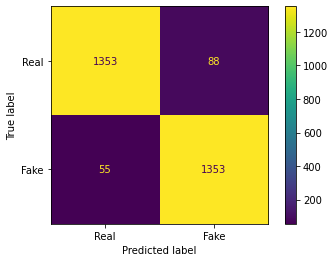

In [ ]:
log_reg = pickle.load(open('/content/sample_data/LogisticRegression_final.pkl', 'rb'))
y_pred = log_reg.predict(X_test_count)

print('Regression Logistique')
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 score :', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Real', 'Fake'])
disp.plot()

Random Forest
Accuracy : 0.9543699543699544
F1 score : 0.9540311173974539


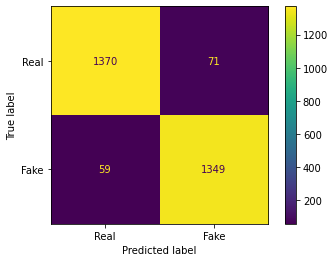

In [ ]:
rfc = pickle.load(open('/content/sample_data/RandomForest_final.pkl', 'rb'))
y_pred = rfc.predict(X_test_count)

print('Random Forest')
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 score :', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Real', 'Fake'])
disp.plot()

Light GBM
Accuracy : 0.952965952965953
F1 score : 0.9528169014084508


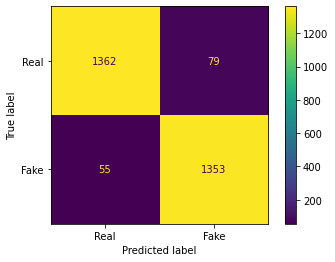

In [ ]:
lgbm = pickle.load(open('/content/sample_data/LGBM_final.pkl', 'rb'))
y_pred = lgbm.predict(X_test_count)

print('Light GBM')
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 score :', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Real', 'Fake'])
disp.plot()

Multi-Layer Perceptron
Accuracy : 0.9613899613899614
F1 score : 0.9612129760225671


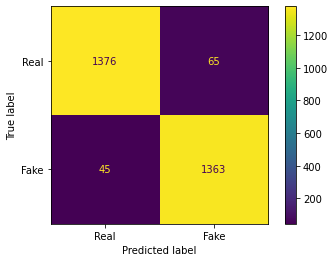

In [ ]:
mlp = pickle.load(open('/content/sample_data/MLP_final.pkl', 'rb'))
y_pred = mlp.predict(X_test_count)

print('Multi-Layer Perceptron')
print('Accuracy :', accuracy_score(y_test, y_pred))
print('F1 score :', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Real', 'Fake'])
disp.plot()

## Ensemble (voting)

Pour encore améliorer les performances, il est possible d'utiliser une méthode d'ensemble i.e. combiner les prédictions des quatre modèles :


*   Regression Logistique
*   Random Forest
*   Multi-layer Perceptron
*   Light Gradient Boosting Machine



Ensemble
Accuracy : 0.965952965952966
F1 score : 0.9658811115019346


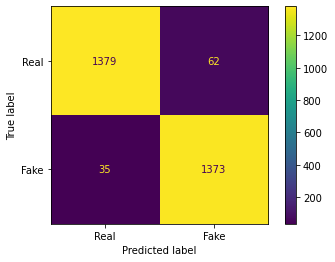

In [ ]:
models = [log_reg, rfc, lgbm, mlp]

y_preds = np.zeros((y_test.shape[0],2))
for model in models :
    y_preds = np.add(model.predict_proba(X_test_count), y_preds)

y_preds = np.argmax(y_preds, axis=1)
print('Ensemble')
print('Accuracy :', accuracy_score(y_test, y_preds))
print('F1 score :', f1_score(y_test, y_preds))
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Real', 'Fake'])
disp.plot()

L'ensemble donne le meilleur résultat !

## Mots les plus importants

Plus le coefficient est grand ou petit et plus ces mots (ou bi-gram) sont importants lors de la prédiction.

Comme vu dans l'exploration des données, les mots twitter et facebook sont très importants dans ce jeu de données !

In [ ]:
word_importance = pd.DataFrame(rfc.feature_importances_, columns = ['Coefficients'], index = rfc.feature_names_in_)
word_importance.sort_values(by='Coefficients', ascending=False).head(30)

Coefficients
twitter               0.046219
partage               0.035728
facebook twitter      0.033472
facebook              0.032117
partage facebook      0.027104
la                    0.018194
de                    0.016418
le                    0.013303
des                   0.012005
les                   0.011767
et                    0.011235
du                    0.010139
en                    0.007735
de la                 0.006966
corse machin          0.005898
est                   0.005672
il                    0.005166
machin                0.005012
pour                  0.004616
une                   0.004595
dans                  0.004466
ce                    0.004356
au                    0.004292
que                   0.004177
qui                   0.004007
etat                  0.003468
paris                 0.003447
mardi                 0.003432
jeudi                 0.003089
un                    0.003066

# Prédiction en direct

Choisir la news à tester et l'écrire dans news = ...

In [ ]:
# Real News
# news = 'Cameroun : trois morts en régions anglophones lors de la fête de la Jeunesse.Depuis le début de la crise, en octobre 2016, vingt-six membres des forces de sécurité ont été tués par des séparatistes présumés en régions anglophones.'

# Fake News
news = 'Un homme se déplace dans l’œil de l’ouragan Irma pour éviter de croiser des gens.C’est l’histoire complètement folle de cette semaine… Tommy Fourne, un français de 43 ans ochlophobe (peur de la foule), a profité du passage de l’œil d’Irma pour enfin sortir de chez lui tout en évitant de croiser du monde. Les journalistes de Boulevard69 qui ont survécu l’ont rencontré pour vous à une distance raisonnable..« C’est mes premières vacances depuis 15 ans ».Dans un premier temps, nous avons tenté de comprendre pourquoi il s’était lancé dans cette aventure périlleuse et comme il a fait pour arriver dans l’œil : « Je ne vous cache pas que c’était compliqué mais ça valait le coup… Quand j’ai vu le bulletin météo, j’ai compris que c’était maintenant ou jamais si je voulais prendre l’air. C’était compliqué, je guettais le ciel pour tenter de voir l’œil du cyclone Irma mais je ne voyais pas grand-chose, je l’ai donc fait à l’instinct et ça m’a réussi même si j’ai failli m’envoler en sortant… Maintenant, comme vous, je suis dans l’œil, il faut savoir que c’est mes premières vacances depuis 15 ans, je ne sais pas si j’aurais la chance de pouvoir voyager encore à l’avenir donc je compte bien profiter de ces quelques jours de repos au maximum avant de reprendre ma vie d’ermite. ».« C’est un peu contraignant pour trouver de la nourriture ».Dans un deuxième temps, nous avons essayé de savoir les contraintes de ce type de vacances et, visiblement, ce n’est pas facile tous les jours : « Je ne vous cache pas que ce n’est pas toujours très reposant, je ne vois personne mais, par conséquent, aucun magasin n’est ouvert non plus, c’est un peu contraignant pour trouver de la nourriture. Heureusement, j’avais prévu le coup et j’avais emporté quelques provisions avec moi… En fait, le plus dur, c’est pour dormir, l’ouragan Irma va vite, je peux donc que me reposer 5 minutes par jour si je veux rester dans l’œil, je commence à fatiguer d’ailleurs… ».On lui souhaite en tout cas de bonnes fins de vacances en espérant que l’ouragan le déposera devant chez lui avant de partir au risque qu’il se retrouve au milieu de la foule.'

Faire tourner toutes les cellules ci-dessous.

In [ ]:
log_reg = pickle.load(open('/content/sample_data/LogisticRegression_final.pkl', 'rb'))
mlp = pickle.load(open('/content/sample_data/MLP_final.pkl', 'rb'))
lgbm = pickle.load(open('/content/sample_data/LGBM_final.pkl', 'rb'))
rfc = pickle.load(open('/content/sample_data/RandomForest_final.pkl', 'rb'))

In [ ]:
news_pp = clean_text(news)
news_words = words.transform(pd.Series([news_pp], dtype=str))
news_bigrams = bigrams.transform(pd.Series([news_pp], dtype=str))
news_f = pd.concat([pd.DataFrame(news_words.toarray(), columns=words.get_feature_names_out()), 
                    pd.DataFrame(news_bigrams.toarray(), columns=bigrams.get_feature_names_out())], axis=1)

In [ ]:
y_pred_log_reg = log_reg.predict(news_f)
y_pred_mlp = mlp.predict(news_f)
y_pred_lgbm = lgbm.predict(news_f)
y_pred_rfc = rfc.predict(news_f)

In [ ]:
print('Prédiction :')
print()
print('Logistic Regression     :', 'Real' if y_pred_log_reg[0] == 0 else 'Fake')
print('Random Forest           :', 'Real' if y_pred_rfc[0] == 0 else 'Fake')
print('Light Gradient Boosting :', 'Real' if y_pred_lgbm[0] == 0 else 'Fake')
print('Multi-layer Perceptron  :', 'Real' if y_pred_mlp[0] == 0 else 'Fake')

Prédiction :

Logistic Regression     : Fake
Random Forest           : Fake
Light Gradient Boosting : Fake
Multi-layer Perceptron  : Fake
